# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings
import re
from notebook_modules.pystan_helpers import StanModel_cache

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

## Data preparation

In [3]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

barcode_sequence                     cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT  ln215_central_nervous_system  1.966515      1   
1  ACAGAAGAAATTCTGGCAGAT  ln382_central_nervous_system  1.289606      1   
2  ACAGAAGAAATTCTGGCAGAT                   efo21_ovary  0.625725      1   
3  ACAGAAGAAATTCTGGCAGAT           jhesoad1_oesophagus  1.392272      1   
4  ACAGAAGAAATTCTGGCAGAT          km12_large_intestine  0.820838      1   

  gene_symbol  
0        EIF6  
1        EIF6  
2        EIF6  
3        EIF6  
4        EIF6

## Exploratory data analysis

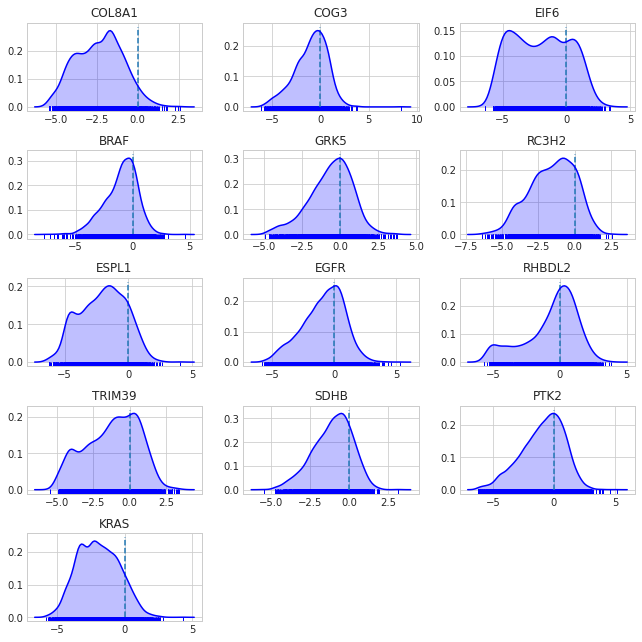

In [4]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, rug=True, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

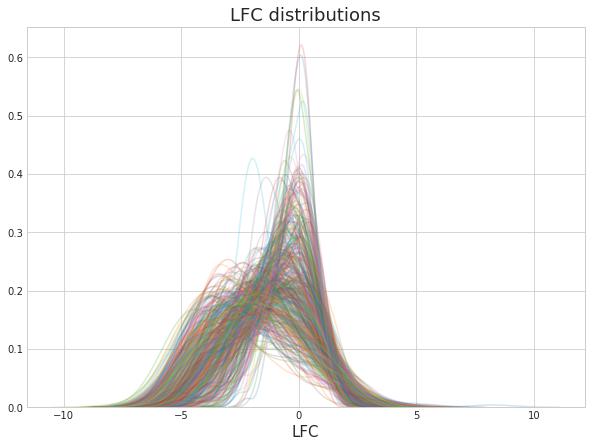

In [5]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

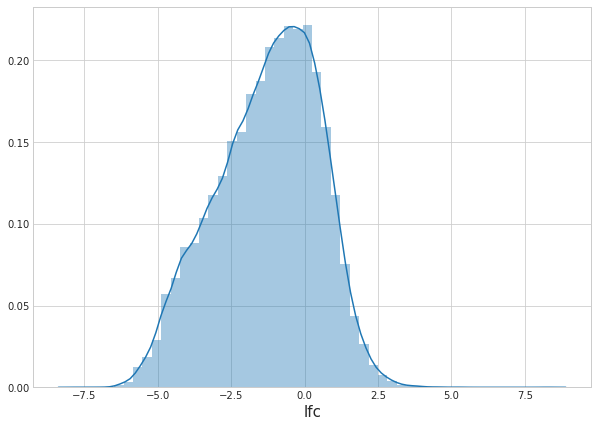

In [6]:
sns.distplot(modeling_data.lfc)
plt.show()

In [7]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

barcode_sequence
gene_symbol                  
BRAF                        8
COG3                        5
COL8A1                      5
EGFR                       19
EIF6                        5
ESPL1                       5
GRK5                        5
KRAS                       11
PTK2                       23
RC3H2                       4
RHBDL2                      5
SDHB                        5
TRIM39                      9

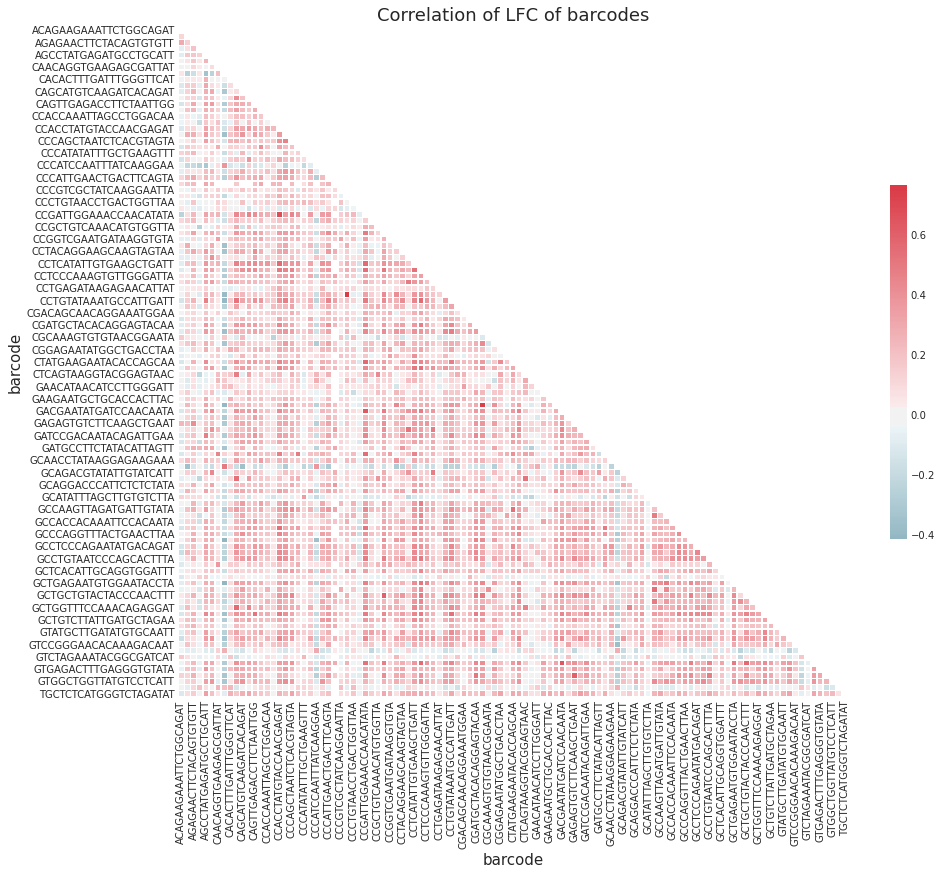

In [8]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [9]:
models_dir = Path('..', 'models')

In [10]:
modeling_data.head()

barcode_sequence                     cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT  ln215_central_nervous_system  1.966515      1   
1  ACAGAAGAAATTCTGGCAGAT  ln382_central_nervous_system  1.289606      1   
2  ACAGAAGAAATTCTGGCAGAT                   efo21_ovary  0.625725      1   
3  ACAGAAGAAATTCTGGCAGAT           jhesoad1_oesophagus  1.392272      1   
4  ACAGAAGAAATTCTGGCAGAT          km12_large_intestine  0.820838      1   

  gene_symbol  
0        EIF6  
1        EIF6  
2        EIF6  
3        EIF6  
4        EIF6

Select only a few cell lines while model building.

In [11]:
len(np.unique(modeling_data.cell_line))

501

In [12]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 40)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(3334, 5)

In [13]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [14]:
# model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
# modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

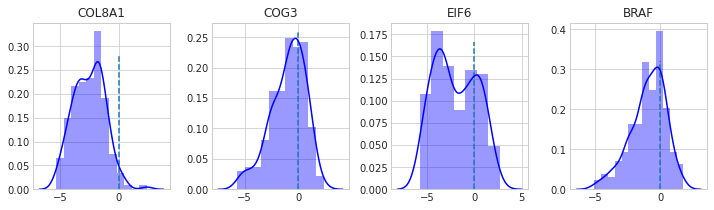

In [15]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=True, ax=ax, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

In [16]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

barcode_sequence                         cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT                       efo21_ovary  0.625725      1   
1  ACAGAAGAAATTCTGGCAGAT  dbtrg05mg_central_nervous_system  2.145082      2   
2  ACAGAAGAAATTCTGGCAGAT                       bt20_breast  0.932751      2   
3  ACAGAAGAAATTCTGGCAGAT     sw1783_central_nervous_system  1.372030      2   
4  ACAGAAGAAATTCTGGCAGAT      kns60_central_nervous_system  0.803835      2   

  gene_symbol  barcode_sequence_idx  cell_line_idx  gene_symbol_idx  
0        EIF6                     1             11                5  
1        EIF6                     1              9                5  
2        EIF6                     1              3                5  
3        EIF6                     1             36                5  
4        EIF6                     1             18                5

Binary matrix of $[shRNA \times gene]$.

In [17]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
shrna_gene_matrix.shape

(109, 13)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [19]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [20]:
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = StanModel_cache(file=d2_m1_file.as_posix())

Using cached StanModel.


In [21]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [23]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha -1.290  0.030  -1.347   -1.235      0.001      0.0    1958.0  1952.0   
sigma  1.736  0.021   1.696    1.775      0.000      0.0    2269.0  2269.0   

       ess_bulk  ess_tail  r_hat  
alpha    1925.0    1230.0    1.0  
sigma    2273.0    1545.0    1.0

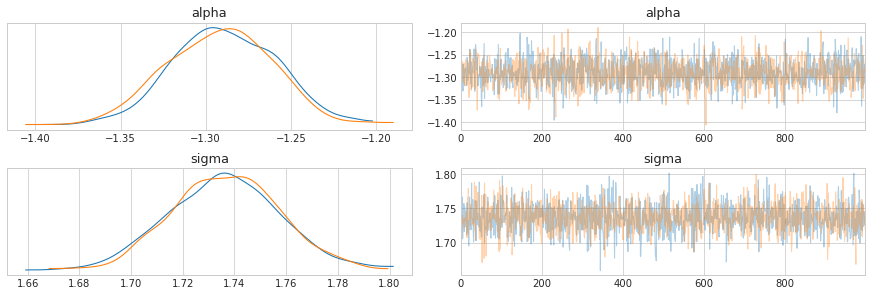

In [24]:
az.plot_trace(az_d2_m1)
plt.show()

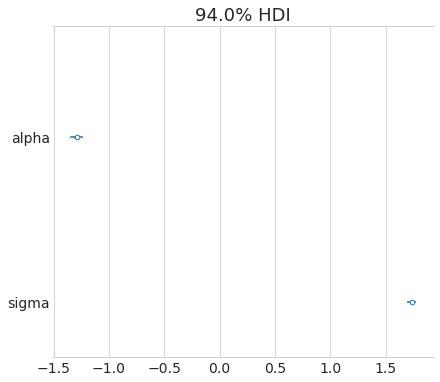

In [25]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

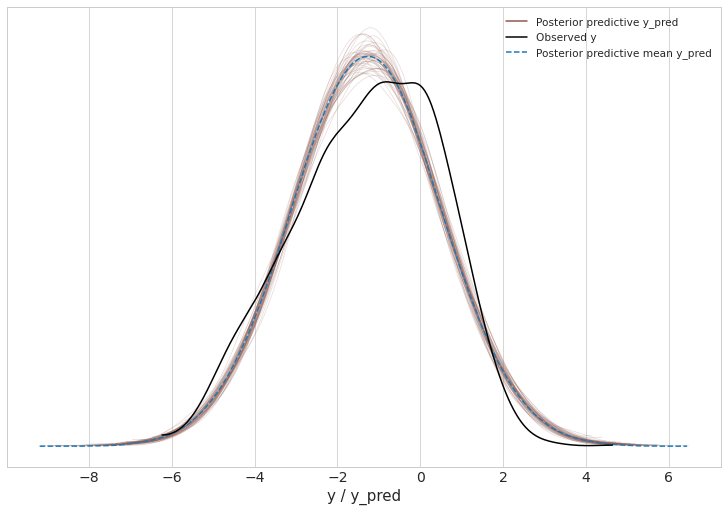

In [26]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [27]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [28]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [29]:
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = StanModel_cache(file=d2_m2_gen_file.as_posix())

Using cached StanModel.


In [30]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, 
                                   iter=10, warmup=0, chains=1, 
                                   algorithm='Fixed_param')

In [31]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

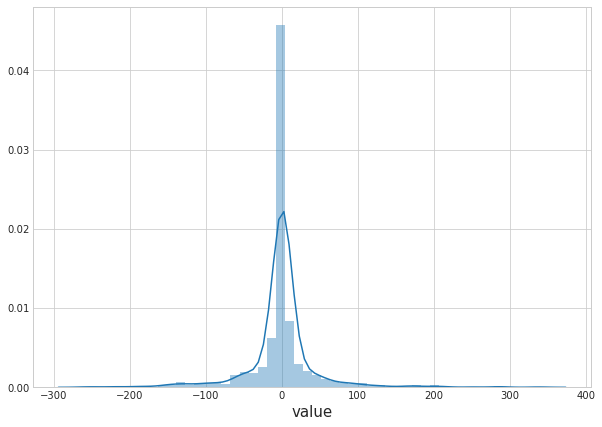

In [32]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

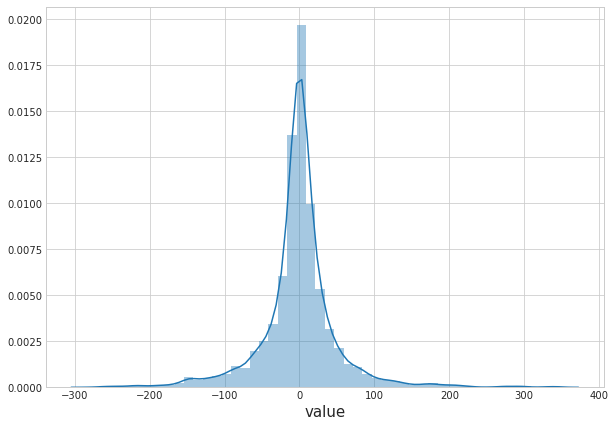

In [33]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

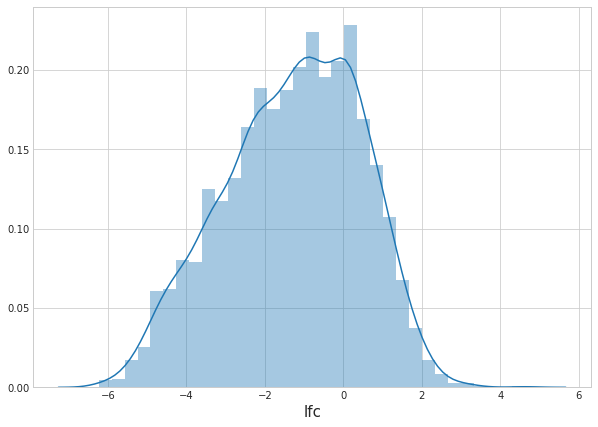

In [34]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [35]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [36]:
d2_m2_data['S']

109

**Compile model.**

In [37]:
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = StanModel_cache(file=d2_m2_file.as_posix())

Using cached StanModel.


In [38]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [39]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [40]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -1.222  0.124  -1.481   -1.001      0.004    0.003    1058.0   
sigma_alpha  1.276  0.087   1.132    1.461      0.003    0.002    1031.0   
alpha[0]     0.714  0.201   0.330    1.062      0.006    0.004    1205.0   
alpha[1]    -0.250  0.190  -0.616    0.087      0.007    0.005     836.0   
alpha[2]    -0.784  0.211  -1.180   -0.395      0.006    0.005    1100.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha     1058.0    1082.0     574.0   1.01  
sigma_alpha  1007.0    1049.0     643.0   1.00  
alpha[0]     1205.0    1252.0     551.0   1.01  
alpha[1]      836.0     847.0     582.0   1.00  
alpha[2]     1047.0    1084.0     668.0   1.00

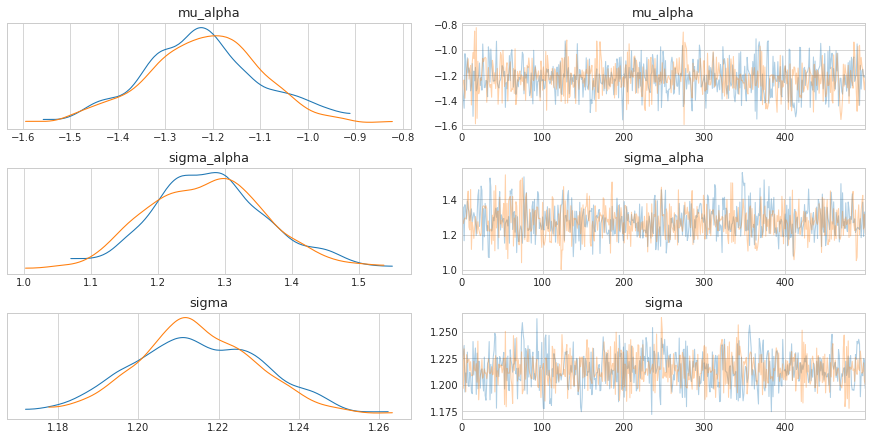

In [41]:
az.plot_trace(az_d2_m2, var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

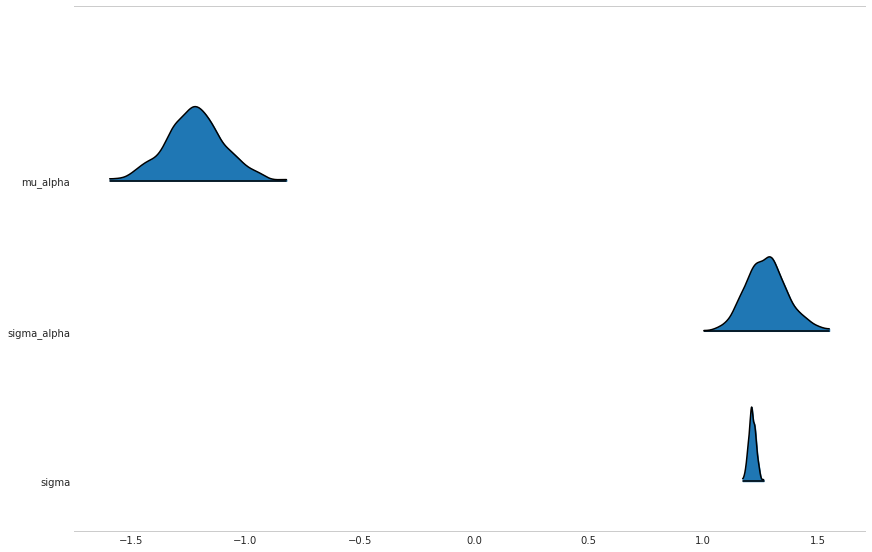

In [42]:
az.plot_forest(az_d2_m2, kind='ridgeplot', combined=True, 
               var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

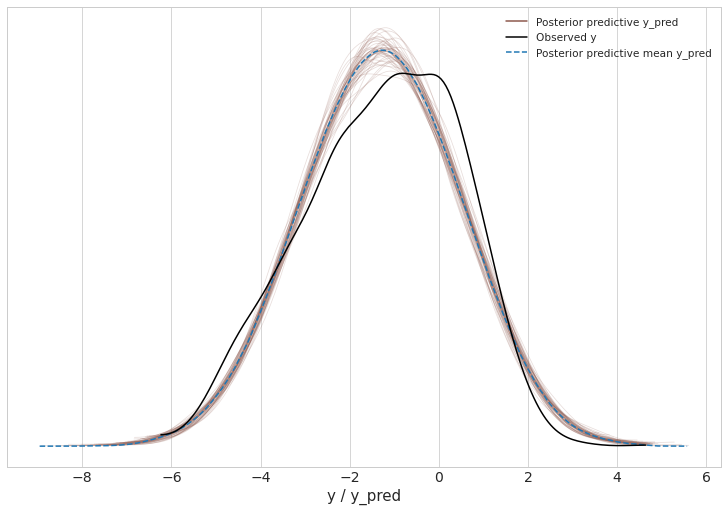

In [43]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [44]:
d2_m2_fit.to_dataframe().head()

chain  draw  warmup  mu_alpha  sigma_alpha  alpha[1]  alpha[2]  alpha[3]  \
0      0     0       0 -1.263567     1.286463  0.691531 -0.410589 -0.486056   
1      0     1       0 -1.294416     1.323071  0.697405 -0.267598 -1.044003   
2      0     2       0 -1.374924     1.356104  0.803428 -0.176478 -1.007182   
3      0     3       0 -1.464064     1.165498  0.857390 -0.004899 -1.059237   
4      0     4       0 -1.029178     1.369234  0.585008 -0.558714 -0.510735   

   alpha[4]  alpha[5]  ...  y_pred[3332]  y_pred[3333]  y_pred[3334]  \
0  0.140605 -2.252227  ...     -1.821982     -4.610282     -0.057629   
1  0.264281 -2.362734  ...      0.730910     -0.803228     -1.128669   
2  0.161903 -2.297076  ...     -3.385013     -1.969810      0.468591   
3 -0.043809 -2.267916  ...      0.264705      0.080555      0.108367   
4  0.471418 -2.217178  ...     -2.383169     -2.772807     -0.843937   

          lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0 -2395.220205       0.834995    0.418915            5            55   
1 -2394.569464       0.937689    0.418915            7           143   
2 -2395.033725       0.853836    0.418915            3            15   
3 -2395.912197       0.954930    0.418915            5            55   
4 -2396.046197       0.936803    0.418915            3             7   

   divergent__     energy__  
0            0  2445.602866  
1            0  2451.366998  
2            0  2456.917527  
3            0  2449.214887  
4            0  2450.746997  

[5 rows x 3456 columns]

## Model 3. Another varying intercept for target gene

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} + g_{i|l}\\
\alpha_s \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
g_l \sim N(\mu_g, \sigma_g) \\
\mu_{\alpha} \sim N(0, 2) \quad \sigma_{\alpha} \sim \text{HalfCauchy}(0, 10) \\
\mu_{g} \sim N(0, 2) \quad \sigma_{g} \sim \text{HalfCauchy}(0, 10) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [45]:
d2_m3_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [46]:
d2_m3_file = models_dir / 'd2_m3.cpp'
d2_m3 = StanModel_cache(file=d2_m3_file.as_posix())

Using cached StanModel.


In [47]:
d2_m3_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m3_fit = d2_m3.sampling(data=d2_m3_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m3_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [48]:
pystan.check_hmc_diagnostics(d2_m3_fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [49]:
az_d2_m3 = az.from_pystan(posterior=d2_m3_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m3)
az.summary(az_d2_m3).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -0.773  1.167  -2.439    1.427      0.270    0.194      19.0   
sigma_alpha  1.242  0.094   1.087    1.430      0.005    0.004     356.0   
mu_g        -0.514  1.164  -2.764    1.165      0.268    0.193      19.0   
sigma_g      0.404  0.219   0.023    0.757      0.017    0.012     166.0   
alpha[0]     1.455  1.224  -0.608    3.800      0.277    0.199      19.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha       19.0      21.0      33.0   1.14  
sigma_alpha   342.0     406.0     281.0   1.01  
mu_g           19.0      21.0      36.0   1.14  
sigma_g       166.0     123.0      71.0   1.03  
alpha[0]       19.0      21.0      37.0   1.14

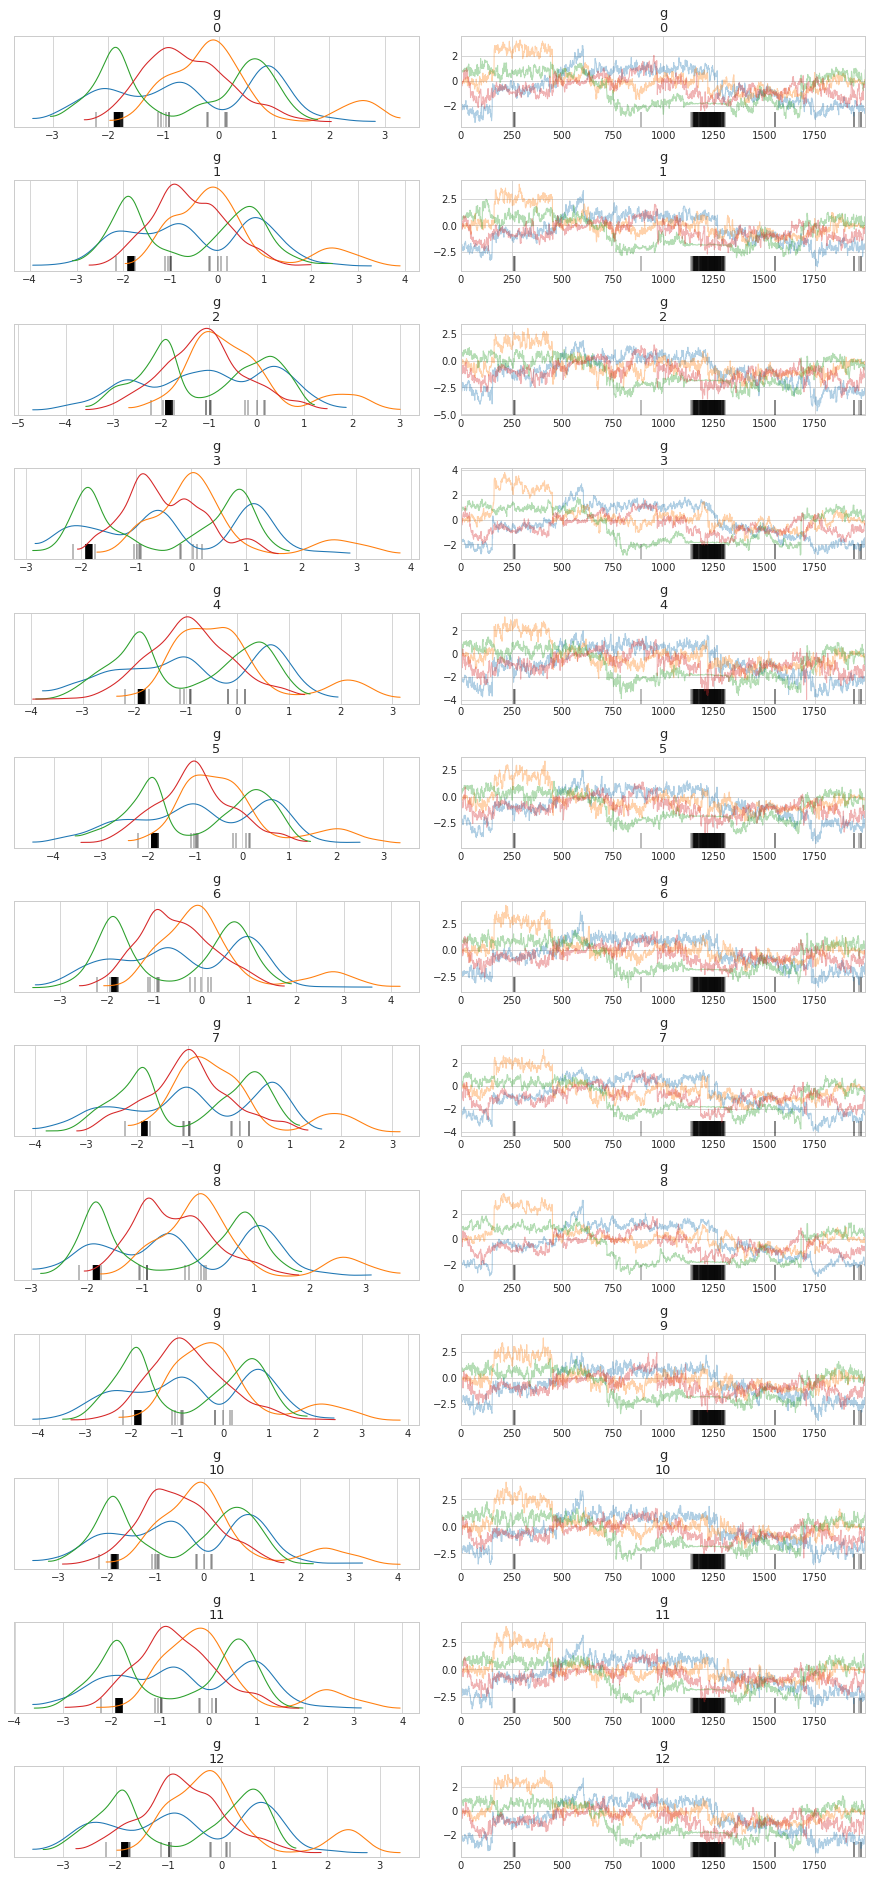

In [50]:
az.plot_trace(az_d2_m3, var_names=['g'])
plt.show()

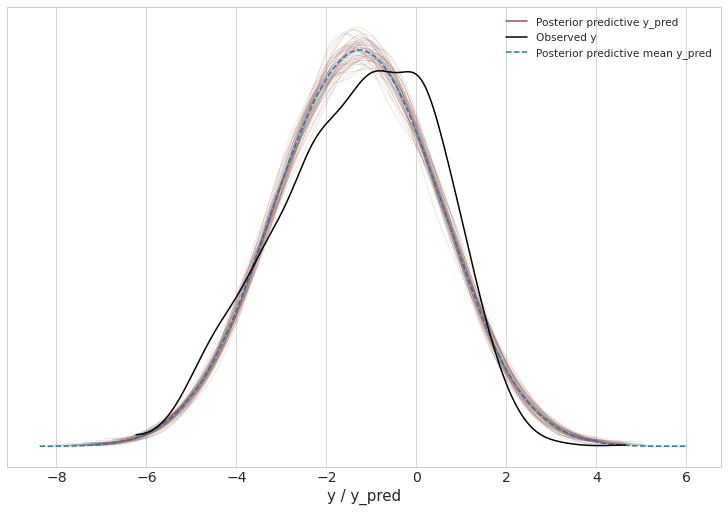

In [51]:
az.plot_ppc(az_d2_m3, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [52]:
fit3_summary = az.summary(az_d2_m3)

In [53]:
fit3_alpha_summary = fit3_summary[fit3_summary.index.str.contains('alpha\[')]
shrna_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_alpha_summary.index]
shrna_idx = [int(a) + 1 for a in shrna_idx]
fit3_alpha_summary = fit3_alpha_summary \
    .assign(barcode_sequence_idx = shrna_idx) \
    .set_index('barcode_sequence_idx') \
    .join(modeling_data[['barcode_sequence_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('barcode_sequence_idx'))
fit3_alpha_summary.head(10)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
barcode_sequence_idx                                                      
1                     1.455  1.224  -0.608    3.800      0.277    0.199   
2                     0.073  1.229  -1.856    2.445      0.271    0.195   
3                    -0.060  1.207  -2.076    2.311      0.268    0.192   
4                     0.496  1.229  -1.501    2.871      0.277    0.199   
5                    -1.351  1.202  -3.423    0.987      0.267    0.191   
6                    -0.715  1.176  -2.763    1.527      0.263    0.189   
7                    -0.446  1.223  -2.388    1.881      0.276    0.198   
8                     1.247  1.198  -0.769    3.530      0.267    0.191   
9                     0.447  1.213  -1.502    2.785      0.274    0.196   
10                   -0.718  1.213  -2.667    1.644      0.271    0.195   

                      ess_mean  ess_sd  ess_bulk  ess_tail  r_hat gene_symbol  
barcode_sequence_idx                                                           
1                         19.0    19.0      21.0      37.0   1.14        EIF6  
2                         21.0    21.0      23.0      33.0   1.13        GRK5  
3                         20.0    20.0      21.0      38.0   1.13        EIF6  
4                         20.0    20.0      22.0      34.0   1.13        EGFR  
5                         20.0    20.0      21.0      38.0   1.13      COL8A1  
6                         20.0    20.0      20.0      36.0   1.14        KRAS  
7                         20.0    20.0      22.0      34.0   1.14        PTK2  
8                         20.0    20.0      22.0      36.0   1.13        PTK2  
9                         20.0    20.0      22.0      36.0   1.13        PTK2  
10                        20.0    20.0      22.0      34.0   1.13        BRAF

In [54]:
fit3_gene_summary = fit3_summary[fit3_summary.index.str.contains('g\[')]
gene_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_gene_summary.index]
gene_idx = [int(a) + 1 for a in gene_idx]
fit3_gene_summary = fit3_gene_summary \
    .assign(gene_symbol_idx = gene_idx) \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('gene_symbol_idx')) \
    .reset_index(drop=False)
fit3_gene_summary.head(10)

gene_symbol_idx   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
0                1 -0.391  1.199  -2.725    1.468      0.272    0.196   
1                2 -0.386  1.227  -2.671    1.768      0.276    0.198   
2                3 -0.906  1.190  -3.291    1.072      0.265    0.190   
3                4 -0.241  1.204  -2.499    1.583      0.278    0.199   
4                5 -0.733  1.196  -3.147    1.178      0.268    0.193   
5                6 -0.792  1.197  -3.210    1.147      0.260    0.187   
6                7 -0.333  1.221  -2.678    1.531      0.273    0.196   
7                8 -0.798  1.166  -3.100    1.077      0.266    0.191   
8                9 -0.222  1.187  -2.405    1.640      0.272    0.195   
9               10 -0.560  1.220  -2.939    1.463      0.257    0.184   

   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat gene_symbol  
0      19.0    19.0      22.0      35.0   1.13        BRAF  
1      20.0    20.0      22.0      34.0   1.14        COG3  
2      20.0    20.0      21.0      36.0   1.14      COL8A1  
3      19.0    19.0      21.0      32.0   1.14        EGFR  
4      20.0    20.0      21.0      37.0   1.14        EIF6  
5      21.0    21.0      22.0      40.0   1.13       ESPL1  
6      20.0    20.0      23.0      35.0   1.13        GRK5  
7      19.0    19.0      20.0      34.0   1.15        KRAS  
8      19.0    19.0      22.0      35.0   1.13        PTK2  
9      23.0    23.0      24.0      40.0   1.12       RC3H2

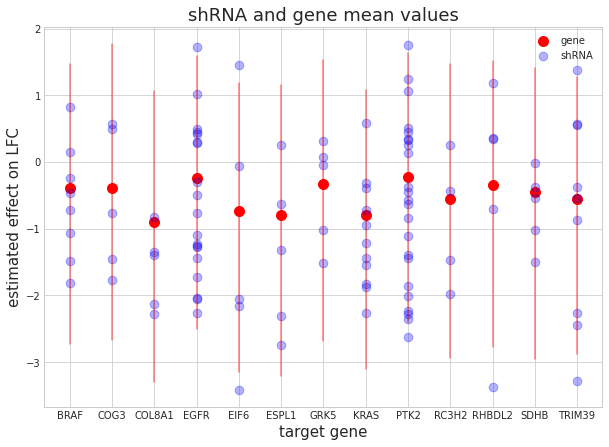

In [55]:
for i in range(fit3_gene_summary.shape[0]):
    plt.plot(np.repeat(fit3_gene_summary.loc[i, 'gene_symbol'], 2), 
             [fit3_gene_summary.loc[i, 'hdi_3%'], fit3_gene_summary.loc[i, 'hdi_97%']],
             color='red', alpha=0.5)


plt.scatter(fit3_gene_summary['gene_symbol'], 
            fit3_gene_summary['mean'],
            s=100, c='r', label='gene')
plt.scatter(fit3_alpha_summary['gene_symbol'], 
            fit3_alpha_summary['mean'], 
            alpha=0.3, s=75, c='b', label='shRNA')

plt.title('shRNA and gene mean values')
plt.xlabel('target gene')
plt.ylabel('estimated effect on LFC')
plt.legend()
plt.show()

## Model 4. Parameters for difference between average gene effect and cell line-specific effect

Note that the varying intercept for shRNA has been renamed from $\alpha$ to $c$.
$\bar g_{l}$ is the average effect of knocking-down gene $l$ while $g_{jl}$ is the cell line $j$-specific effect of knocking-down $l$.

There is now also varying population level standard deviations for each shRNA $\sigma_s$.
This seems to help reduce divergences during sampling by modeling differences in standard deviation for each shRNA.

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma_s) \\
\mu = c_{i|s} + \bar g_{i|l} + g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [56]:
d2_m4_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [57]:
d2_m4_file = models_dir / 'd2_m4.cpp'
d2_m4 = StanModel_cache(file=d2_m4_file.as_posix())

Using cached StanModel.


In [58]:
d2_m4_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m4_fit = d2_m4.sampling(data=d2_m4_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m4_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [59]:
pystan.check_hmc_diagnostics(d2_m4_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [60]:
az_d2_m4 = az.from_pystan(posterior=d2_m4_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m4)
az.summary(az_d2_m4).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
sigma_c     1.237  0.092   1.068    1.410      0.001    0.001    5649.0   
mu_gbar    -1.271  0.181  -1.627   -0.944      0.005    0.003    1339.0   
sigma_gbar  0.397  0.215   0.010    0.746      0.010    0.007     470.0   
sigma_g     0.460  0.031   0.402    0.519      0.001    0.000    2010.0   
c[0]        2.236  0.390   1.531    2.993      0.010    0.007    1432.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
sigma_c     5594.0    5720.0    5594.0   1.00  
mu_gbar     1339.0    1324.0    3014.0   1.00  
sigma_gbar   470.0     355.0     157.0   1.01  
sigma_g     2010.0    2007.0    3988.0   1.00  
c[0]        1353.0    1527.0    2343.0   1.00

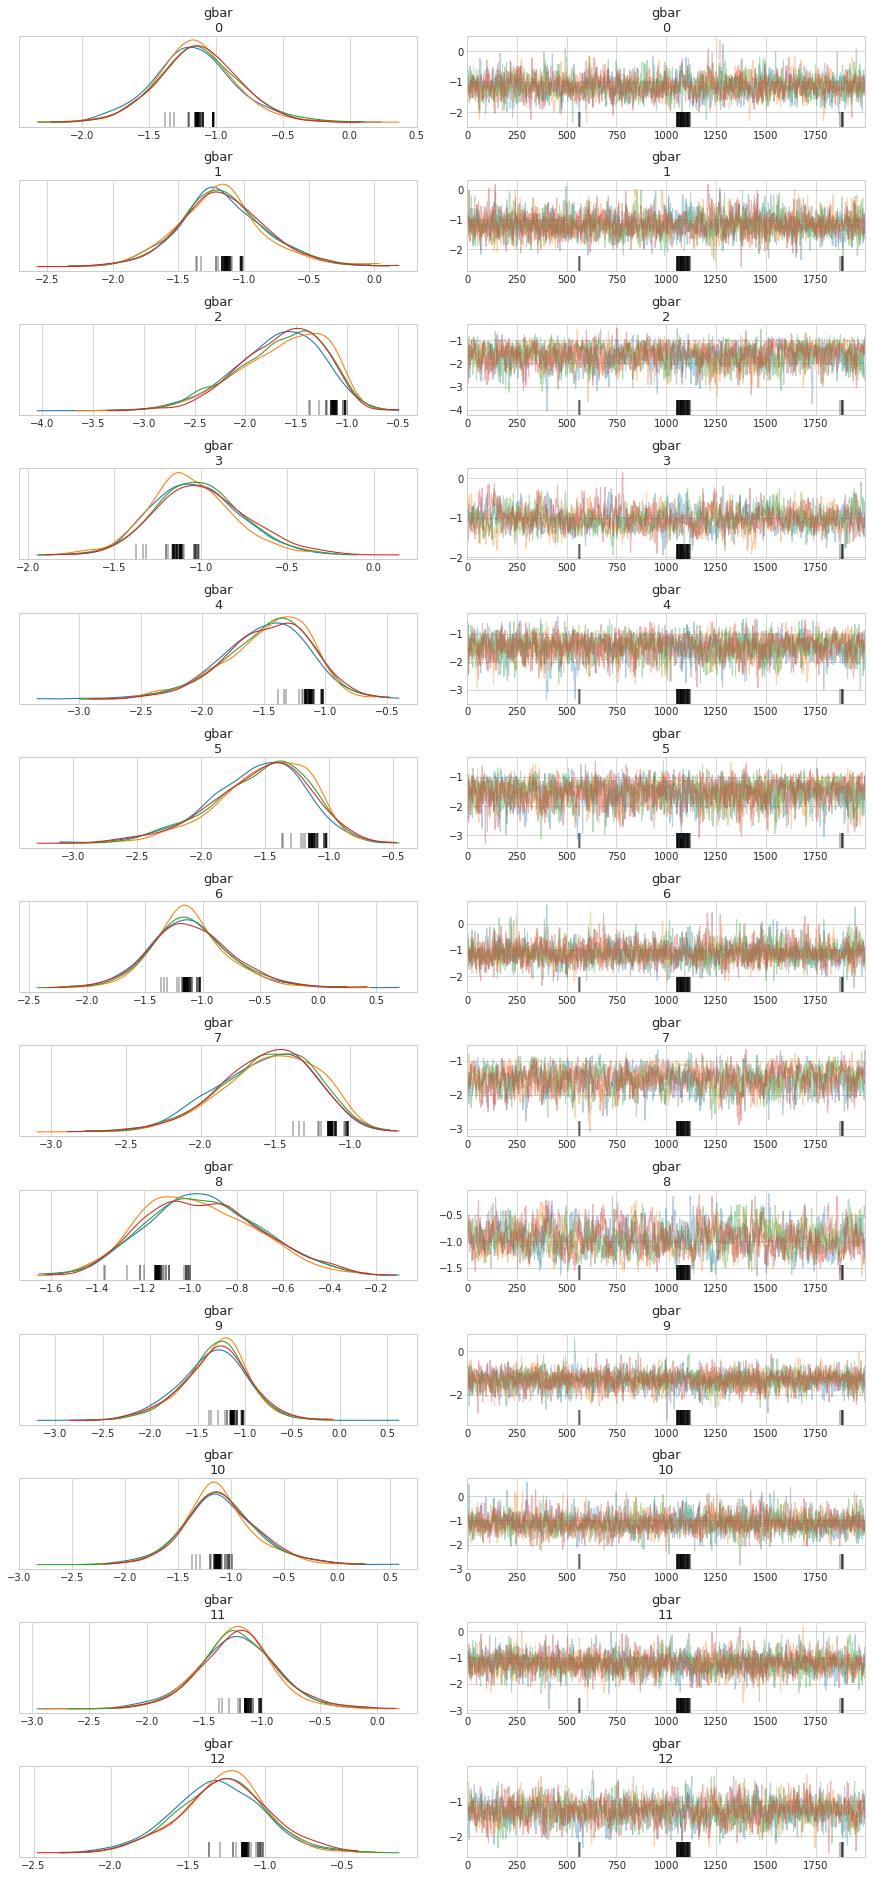

In [61]:
az.plot_trace(az_d2_m4, var_names=['gbar'])
plt.show()

In [62]:
az.summary(az_d2_m4).tail()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
sigma[104]  1.038  0.141   0.764    1.294      0.002    0.001    5822.0   
sigma[105]  0.982  0.115   0.779    1.206      0.001    0.001    6993.0   
sigma[106]  1.208  0.131   0.964    1.455      0.001    0.001   10173.0   
sigma[107]  1.054  0.136   0.798    1.303      0.001    0.001   14240.0   
sigma[108]  1.084  0.135   0.843    1.343      0.001    0.001   14609.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
sigma[104]   5822.0    5130.0     914.0    1.0  
sigma[105]   6993.0    6701.0     894.0    1.0  
sigma[106]   9510.0   10729.0    6237.0    1.0  
sigma[107]  13164.0   14626.0    5427.0    1.0  
sigma[108]  13624.0   15001.0    5716.0    1.0

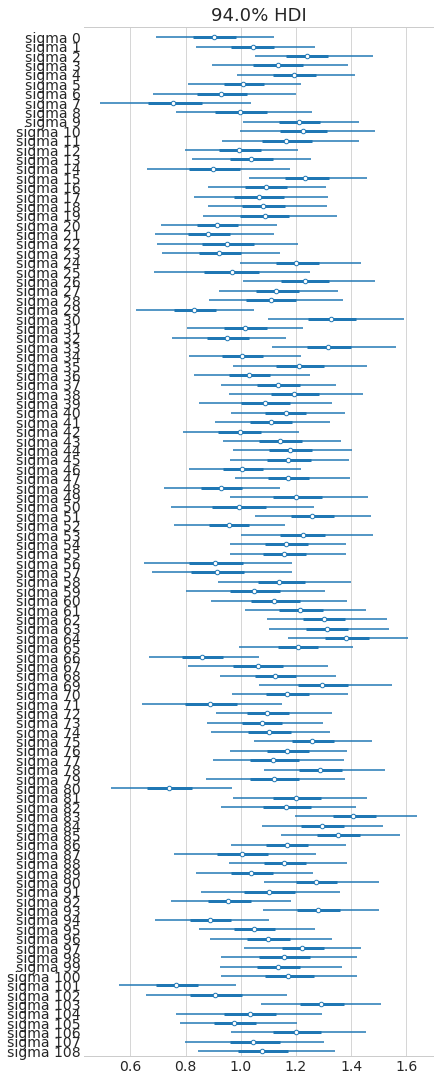

In [63]:
az.plot_forest(az_d2_m4, var_names=['sigma'], combined=True)
plt.show()

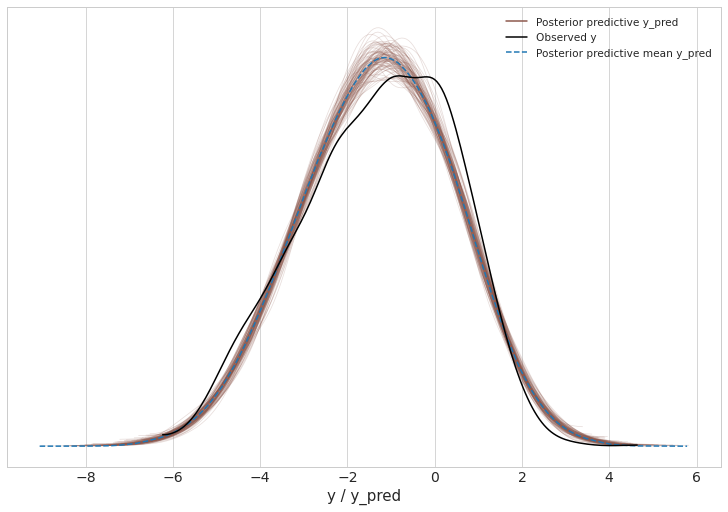

In [64]:
az.plot_ppc(az_d2_m4, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [65]:
g_jl_post = d2_m4_fit.to_dataframe() \
    .melt(id_vars=['chain', 'draw', 'warmup']) \
    .pipe(lambda d: d[d.variable.str.contains('g\[')])

In [66]:
g_jl_post.head()

chain  draw  warmup variable     value
1008000      0     0       0   g[1,1] -0.430680
1008001      0     1       0   g[1,1]  0.238186
1008002      0     2       0   g[1,1]  0.170318
1008003      0     3       0   g[1,1]  0.149008
1008004      0     4       0   g[1,1]  0.331115

In [67]:
def extract_g_index(s, i=0, outside_text='g[]'):
    s_mod = [a.strip(outside_text) for a in s]
    s_mod = [a.split(',') for a in s_mod]
    s_mod = [a[i].strip() for a in s_mod]
    return s_mod

In [68]:
g_jl_post = g_jl_post \
    .assign(cell_line_idx=lambda x: extract_g_index(x.variable.to_list(), i=0),
            gene_symbol_idx=lambda x: extract_g_index(x.variable.to_list(), i=1)) \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .groupby(['cell_line_idx', 'gene_symbol_idx']) \
    .mean() \
    .reset_index() \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .set_index('cell_line_idx') \
    .join(modeling_data[['cell_line', 'cell_line_idx']] \
              .drop_duplicates() \
              .astype({'cell_line_idx': int}) \
              .set_index('cell_line_idx'),
          how='left') \
    .reset_index() \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol', 'gene_symbol_idx']] \
              .drop_duplicates() \
              .astype({'gene_symbol_idx': int}) \
              .set_index('gene_symbol_idx'),
          how='left') \
    .reset_index() \
    .assign(gene_symbol=lambda x: [f'{a} ({b})' for a,b in zip(x.gene_symbol, x.gene_symbol_idx)],
            cell_line=lambda x: [f'{a} ({b})' for a,b in zip(x.cell_line, x.cell_line_idx)]) \
    .drop(['gene_symbol_idx', 'cell_line_idx'], axis=1) \
    .pivot(index='gene_symbol', columns='cell_line', values='value')

In [69]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

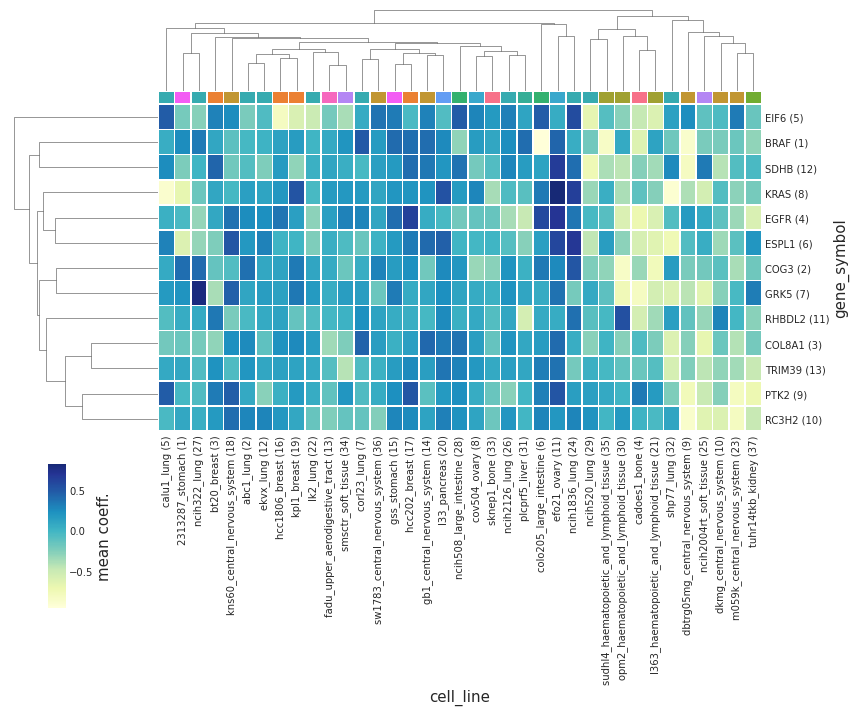

In [70]:
# Color bar for tissue of origin of cell lines.
cell_line_origin = g_jl_post.columns.to_list()
cell_line_origin = [a.split(' ')[0] for a in cell_line_origin]
cell_line_origin = [a.split('_')[1:] for a in cell_line_origin]
cell_line_origin = [' '.join(a) for a in cell_line_origin]

cell_line_pal = sns.husl_palette(len(np.unique(cell_line_origin)), s=.90)
cell_line_lut = dict(zip(np.unique(cell_line_origin), cell_line_pal))

cell_line_colors = pd.Series(cell_line_origin, index=g_jl_post.columns).map(cell_line_lut)

np.random.seed(123)
row_linkage = hierarchy.linkage(distance.pdist(g_jl_post), method='average')

p = sns.clustermap(g_jl_post, center=0, cmap="YlGnBu", linewidths=0.5, 
                   figsize=(12, 10),
                   cbar_kws={'label': 'mean coeff.'},
                   cbar_pos=[0.06, 0.15, 0.02, 0.2],
                   row_linkage=row_linkage,
                   col_colors=cell_line_colors)

In [71]:
d2_m4_post = d2_m4_fit.to_dataframe()

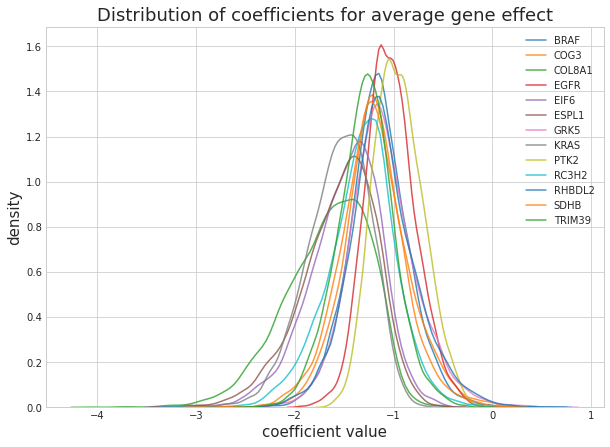

In [72]:
genes_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

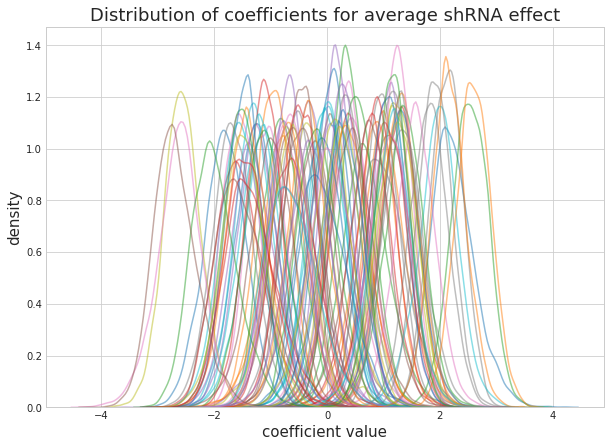

In [73]:
cell_lines_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('c\[')]

for col in cell_lines_post.columns.to_list():
    sns.distplot(cell_lines_post[[col]], hist=False, kde_kws={'shade': False, 'alpha': 0.5})

plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average shRNA effect')
plt.show()

## Model 5. Multiplicative scaling factor of each shRNA

In the original DEMETER2 paper, the model includes a multiplicative scaling factor for each shRNA, constrained between 0 and 1, along with the addative varying effect for each shRNA.
The factor is multiplied against the gene effect.

In this model, I experiment with this multiplicative factor $\alpha_s$.

$$
D_{i|s} \sim N(\mu_{i|sjl}, \sigma_s) \\
\mu_{sjl}= c_{s} + \alpha_{s} (\bar g_{l} + g_{jl}) \\
c_s \sim N(0, \sigma_c) \\
\alpha_s \sim \text{Uniform}(0, 1) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [74]:
d2_m5_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

In [75]:
d2_m5_file = models_dir / 'd2_m5.cpp'
d2_m5 = StanModel_cache(file=d2_m5_file.as_posix())

Using cached StanModel.


In [117]:
d2_m5_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m5_fit = d2_m5.sampling(data=d2_m5_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m5_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [77]:
pystan.check_hmc_diagnostics(d2_m5_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [78]:
d2_m5_post = d2_m5_fit.to_dataframe()

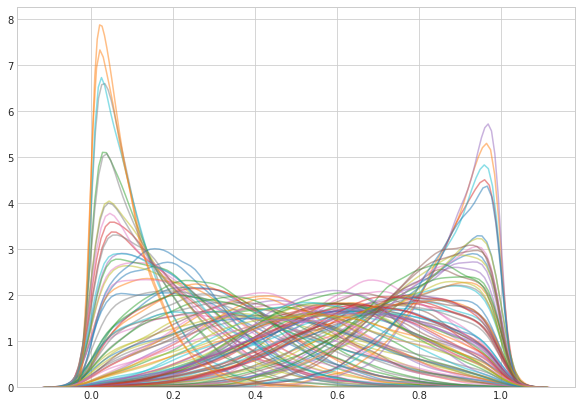

In [79]:
df = d2_m5_post.loc[:, d2_m5_post.columns.str.contains('alpha\[')]
for col in df.columns:
    sns.distplot(df[[col]], hist=False, kde_kws={'alpha': 0.5})

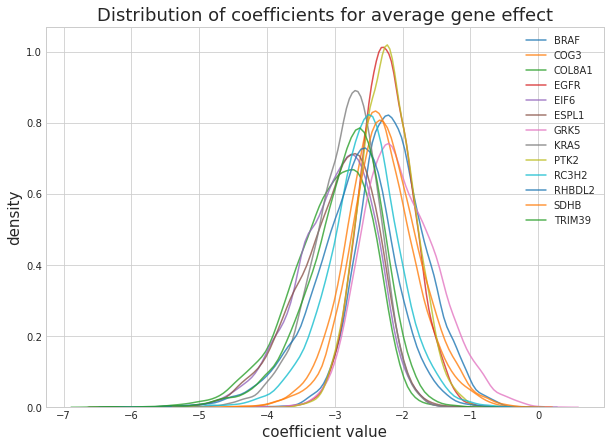

In [80]:
genes_post = d2_m5_post.loc[:, d2_m5_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

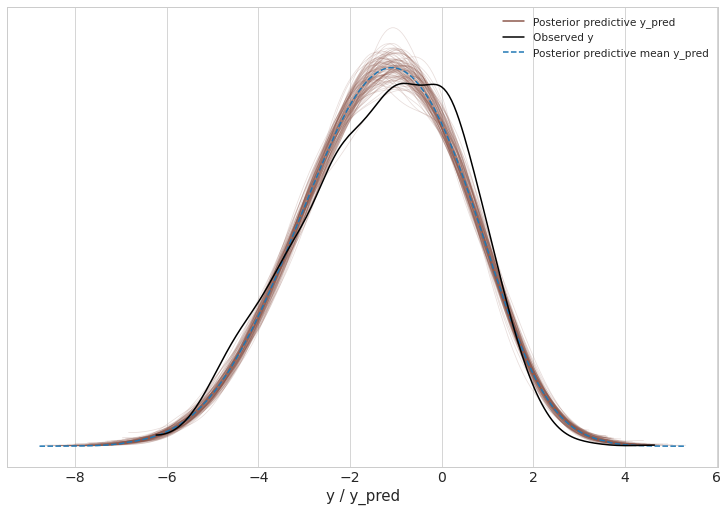

In [81]:
az_d2_m5 = az.from_pystan(posterior=d2_m5_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m5)
az.plot_ppc(az_d2_m5, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [82]:
g_jl_post = d2_m5_fit.to_dataframe() \
    .melt(id_vars=['chain', 'draw', 'warmup']) \
    .pipe(lambda d: d[d.variable.str.contains('g\[')])

In [83]:
g_jl_post = g_jl_post \
    .assign(cell_line_idx=lambda x: extract_g_index(x.variable.to_list(), i=0),
            gene_symbol_idx=lambda x: extract_g_index(x.variable.to_list(), i=1)) \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .groupby(['cell_line_idx', 'gene_symbol_idx']) \
    .mean() \
    .reset_index() \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .set_index('cell_line_idx') \
    .join(modeling_data[['cell_line', 'cell_line_idx']] \
              .drop_duplicates() \
              .astype({'cell_line_idx': int}) \
              .set_index('cell_line_idx'),
          how='left') \
    .reset_index() \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol', 'gene_symbol_idx']] \
              .drop_duplicates() \
              .astype({'gene_symbol_idx': int}) \
              .set_index('gene_symbol_idx'),
          how='left') \
    .reset_index() \
    .assign(gene_symbol=lambda x: [f'{a} ({b})' for a,b in zip(x.gene_symbol, x.gene_symbol_idx)],
            cell_line=lambda x: [f'{a} ({b})' for a,b in zip(x.cell_line, x.cell_line_idx)]) \
    .drop(['gene_symbol_idx', 'cell_line_idx'], axis=1) \
    .pivot(index='gene_symbol', columns='cell_line', values='value')

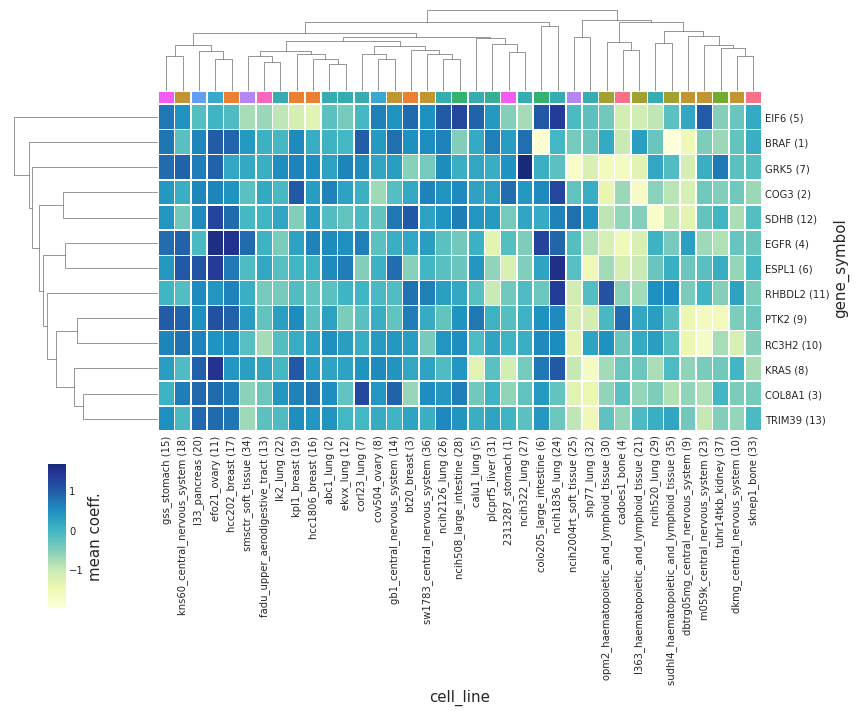

In [84]:
# Color bar for tissue of origin of cell lines.
cell_line_origin = g_jl_post.columns.to_list()
cell_line_origin = [a.split(' ')[0] for a in cell_line_origin]
cell_line_origin = [a.split('_')[1:] for a in cell_line_origin]
cell_line_origin = [' '.join(a) for a in cell_line_origin]

cell_line_pal = sns.husl_palette(len(np.unique(cell_line_origin)), s=.90)
cell_line_lut = dict(zip(np.unique(cell_line_origin), cell_line_pal))

cell_line_colors = pd.Series(cell_line_origin, index=g_jl_post.columns).map(cell_line_lut)

np.random.seed(123)
row_linkage = hierarchy.linkage(distance.pdist(g_jl_post), method='average')

p = sns.clustermap(g_jl_post, center=0, cmap="YlGnBu", linewidths=0.5, 
                   figsize=(12, 10),
                   cbar_kws={'label': 'mean coeff.'},
                   cbar_pos=[0.06, 0.15, 0.02, 0.2],
                   row_linkage=row_linkage,
                   col_colors=cell_line_colors)

In [85]:
y_pred = d2_m5_fit.extract(pars='y_pred')['y_pred']
y_pred.shape

(8000, 3334)

In [86]:
m5_pred_mean = np.apply_along_axis(np.mean, 0, y_pred)
m5_pred_hdi = np.apply_along_axis(az.hdi, 0, y_pred, hdi_prob=0.89)
d2_m5_pred = pd.DataFrame({
    'pred_mean': m5_pred_mean, 
    'pred_hdi_low': m5_pred_hdi[0], 
    'pred_hdi_high': m5_pred_hdi[1],
    'obs': d2_m5_data['y'],
    'barcode_sequence_idx': d2_m5_data['shrna'],
    'gene_idx': d2_m5_data['gene'],
    'cell_line_idx': d2_m5_data['cell_line'],
    'barcode_sequence': modeling_data.barcode_sequence,
    'gene_symbol': modeling_data.gene_symbol,
    'cell_line': modeling_data.cell_line,
})
d2_m5_pred

pred_mean  pred_hdi_low  pred_hdi_high       obs  barcode_sequence_idx  \
0      0.742871     -0.748287       2.329097  0.625725                     1   
1      0.779841     -0.867941       2.339018  2.145082                     1   
2      0.936184     -0.649361       2.477397  0.932751                     1   
3      0.876974     -0.743851       2.407862  1.372030                     1   
4      0.827171     -0.709087       2.426900  0.803835                     1   
...         ...           ...            ...       ...                   ...   
3329  -1.836322     -3.815350      -0.067366 -3.118520                   109   
3330  -1.130218     -2.953949       0.672288 -1.858803                   109   
3331  -1.417122     -3.211824       0.425783 -2.398997                   109   
3332  -0.897946     -2.644816       0.899824  0.948492                   109   
3333  -1.335326     -3.045359       0.599845 -2.847713                   109   

      gene_idx  cell_line_idx       barcode_sequence gene_symbol  \
0            5             11  ACAGAAGAAATTCTGGCAGAT        EIF6   
1            5              9  ACAGAAGAAATTCTGGCAGAT        EIF6   
2            5              3  ACAGAAGAAATTCTGGCAGAT        EIF6   
3            5             36  ACAGAAGAAATTCTGGCAGAT        EIF6   
4            5             18  ACAGAAGAAATTCTGGCAGAT        EIF6   
...        ...            ...                    ...         ...   
3329        13             32  TGCTCTCATGGGTCTAGATAT      TRIM39   
3330        13             33  TGCTCTCATGGGTCTAGATAT      TRIM39   
3331        13             34  TGCTCTCATGGGTCTAGATAT      TRIM39   
3332        13             35  TGCTCTCATGGGTCTAGATAT      TRIM39   
3333        13             37  TGCTCTCATGGGTCTAGATAT      TRIM39   

                                      cell_line  
0                                   efo21_ovary  
1              dbtrg05mg_central_nervous_system  
2                                   bt20_breast  
3                 sw1783_central_nervous_system  
4                  kns60_central_nervous_system  
...                                         ...  
3329                                 shp77_lung  
3330                                sknep1_bone  
3331                         smsctr_soft_tissue  
3332  sudhl4_haematopoietic_and_lymphoid_tissue  
3333                           tuhr14tkb_kidney  

[3334 rows x 10 columns]

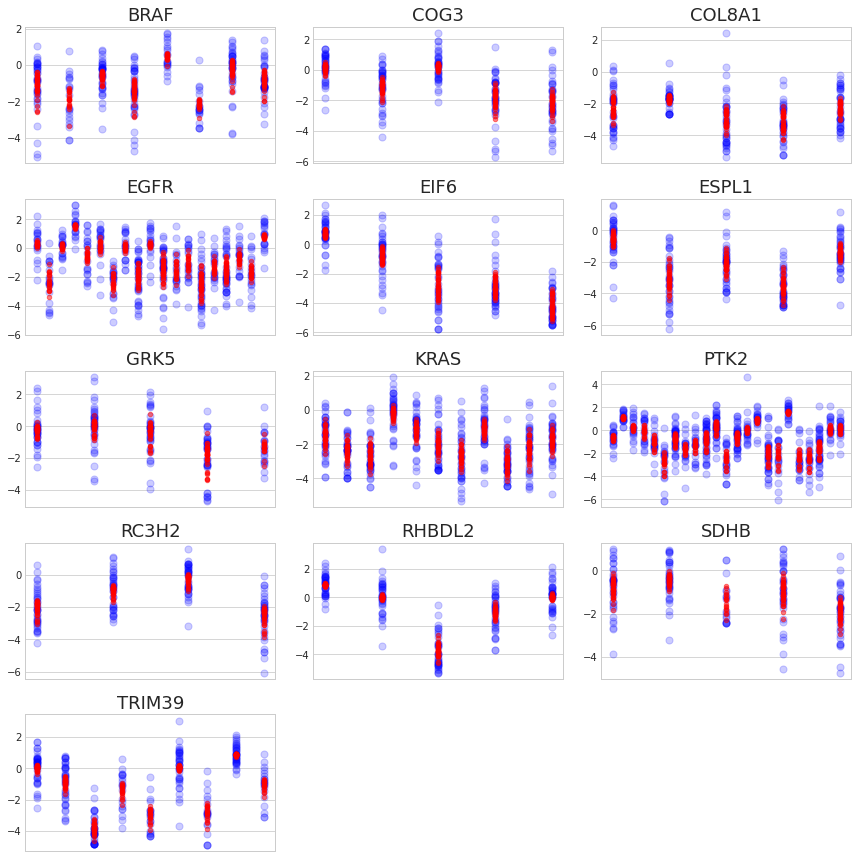

In [87]:
genes = list(np.unique(d2_m5_pred.gene_symbol))
genes.sort()

fig, axes = plt.subplots(5, 3, figsize=(12, 12))

for ax, gene in zip(axes.flatten(), genes):
    df = d2_m5_pred[d2_m5_pred.gene_symbol == gene]
    ax.scatter(df.barcode_sequence, df.obs, color='blue', s=50, alpha=0.2)
    ax.scatter(df.barcode_sequence, df.pred_mean, color='red', s=20, alpha=0.5)
    ax.xaxis.set_ticks([])
    ax.set_title(gene)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

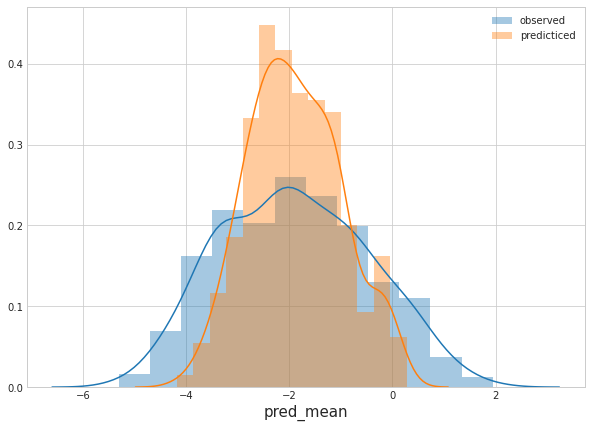

In [88]:
sns.distplot(d2_m5_pred[d2_m5_pred.gene_symbol == 'KRAS'].obs, label='observed')
sns.distplot(d2_m5_pred[d2_m5_pred.gene_symbol == 'KRAS'].pred_mean, label='predicticed')
plt.legend()
plt.show()

In [89]:
g_pred = d2_m5_fit.to_dataframe()
g_pred_cols = g_pred.columns[g_pred.columns.str.contains('g\[')].to_list()
g_pred = g_pred[['chain', 'draw', 'warmup'] + g_pred_cols] \
    .set_index(['chain', 'draw', 'warmup']) \
    .melt() \
    .assign(cell_line_idx=lambda x: [int(a) for a in extract_g_index(x.variable)],
            gene_symbol_idx=lambda x: [int(a) for a in extract_g_index(x.variable, i=1)])

g_pred.head()

variable     value  cell_line_idx  gene_symbol_idx
0   g[1,1] -0.072524              1                1
1   g[1,1]  0.342332              1                1
2   g[1,1]  0.187223              1                1
3   g[1,1]  0.253825              1                1
4   g[1,1]  0.318944              1                1

In [90]:
cell_line_gene_idx_map = modeling_data \
    [['cell_line_idx', 'gene_symbol_idx', 'cell_line', 'gene_symbol']] \
    .drop_duplicates() \
    .set_index(['cell_line_idx', 'gene_symbol_idx'])
cell_line_gene_idx_map.head()

cell_line gene_symbol
cell_line_idx gene_symbol_idx                                              
11            5                                     efo21_ovary        EIF6
9             5                dbtrg05mg_central_nervous_system        EIF6
3             5                                     bt20_breast        EIF6
36            5                   sw1783_central_nervous_system        EIF6
18            5                    kns60_central_nervous_system        EIF6

In [91]:
g_pred = g_pred.set_index(['cell_line_idx', 'gene_symbol_idx']) \
    .join(cell_line_gene_idx_map, how='left') \
    .reset_index()
g_pred.head()

cell_line_idx  gene_symbol_idx variable     value        cell_line  \
0              1                1   g[1,1] -0.072524  2313287_stomach   
1              1                1   g[1,1]  0.342332  2313287_stomach   
2              1                1   g[1,1]  0.187223  2313287_stomach   
3              1                1   g[1,1]  0.253825  2313287_stomach   
4              1                1   g[1,1]  0.318944  2313287_stomach   

  gene_symbol  
0        BRAF  
1        BRAF  
2        BRAF  
3        BRAF  
4        BRAF

In [92]:
kras_muts = pd.read_csv(modeling_data_dir / 'kras_mutants.csv') \
    .assign(cell_line=lambda x: [a.lower() for a in x.cell_line])
kras_muts

cell_line protein_change
0                                  a427_lung         p.G12D
1                                  a549_lung         p.G12S
2                                ags_stomach         p.G12D
3    amo1_haematopoietic_and_lymphoid_tissue        p.A146T
4                             aspc1_pancreas         p.G12D
..                                       ...            ...
109                    sw948_large_intestine         p.Q61L
110                         tccpan2_pancreas         p.G12R
111                             tov21g_ovary         p.G13C
112                      umuc3_urinary_tract         p.G12C
113            yd8_upper_aerodigestive_tract        p.G138V

[114 rows x 2 columns]

In [93]:
def violin_by_cell_line(target_gene, mut_gene, mut_cell_lines):
    df = g_pred.pipe(lambda x: x[x.gene_symbol == target_gene])

    cell_line_order = df.groupby('cell_line').mean().sort_values('value').reset_index().cell_line.to_list()
    df = df.set_index('cell_line').loc[cell_line_order].reset_index()
    df = df.assign(mut=lambda x: x.cell_line.isin(mut_cell_lines))

    fig = plt.figure(figsize=(15, 5))
    plt.axhline(y=0, c='k', alpha=0.4, ls='--')
    sns.violinplot('cell_line', 'value', hue='mut', data=df, dodge=False)
    plt.xticks(rotation=60, ha='right')
    plt.title(f'{target_gene} essentiality for {mut_gene} mutant cell lines')
    plt.xlabel(None)
    plt.ylabel('gene effect coeff.')
    plt.legend(title=f'{mut_gene} mut.')
    plt.show()

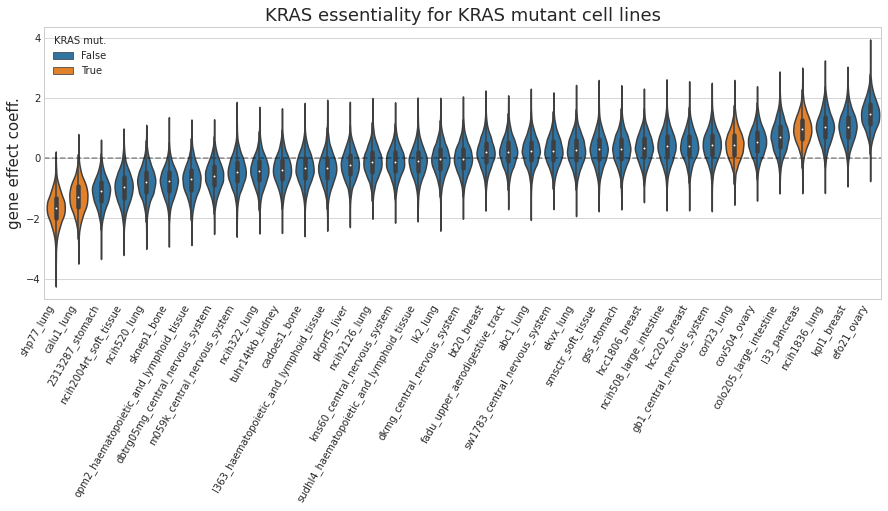

In [94]:
violin_by_cell_line('KRAS', 'KRAS', kras_muts.cell_line)

In [95]:
mutation_data = pd.read_csv(modeling_data_dir / 'ccle_mutations.csv') \
    .assign(cell_line=lambda x: [a.lower() for a in x.tumor_sample_barcode]) \
    .pipe(lambda x: x[x.cell_line.isin(g_pred.cell_line)]) \
    .reset_index(drop=True)
mutation_data.head()

tumor_sample_barcode hugo_symbol chromosome  start_position  end_position  \
0         CADOES1_BONE       NPHP4          1         5935092       5935092   
1         CADOES1_BONE        CHD5          1         6202224       6202224   
2         CADOES1_BONE     SLC45A1          1         8404071       8404071   
3         CADOES1_BONE    PRAMEF10          1        12954514      12954514   
4         CADOES1_BONE       NBPF1          1        16892276      16892276   

     variant_classification variant_type protein_change     cell_line  
0                    Silent          SNP        p.T962T  cadoes1_bone  
1  De_novo_Start_OutOfFrame          SNP            NaN  cadoes1_bone  
2          Nonstop_Mutation          SNP        p.*749R  cadoes1_bone  
3         Missense_Mutation          SNP        p.P257S  cadoes1_bone  
4                    Silent          SNP        p.A972A  cadoes1_bone

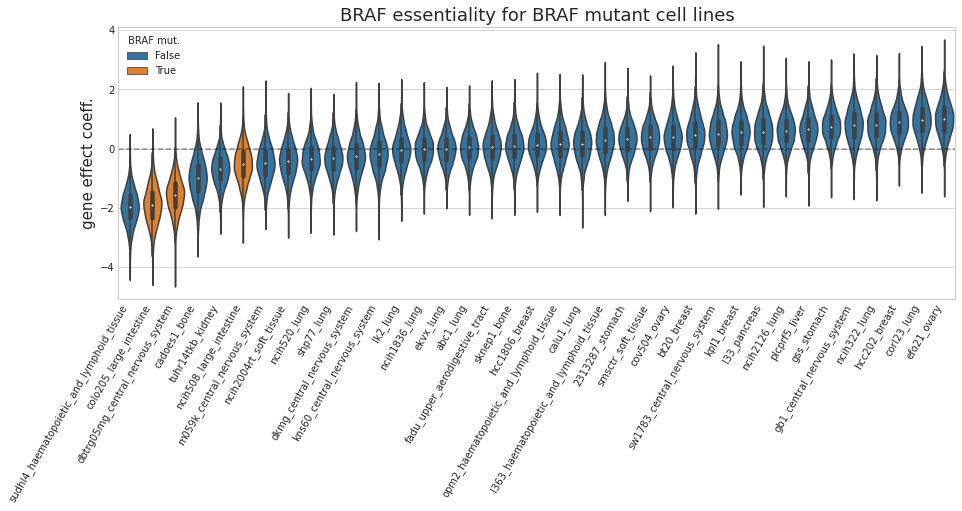

In [96]:
braf_muts = mutation_data.pipe(lambda x: x[x.hugo_symbol == 'BRAF'])
violin_by_cell_line('BRAF', 'BRAF', braf_muts.cell_line)

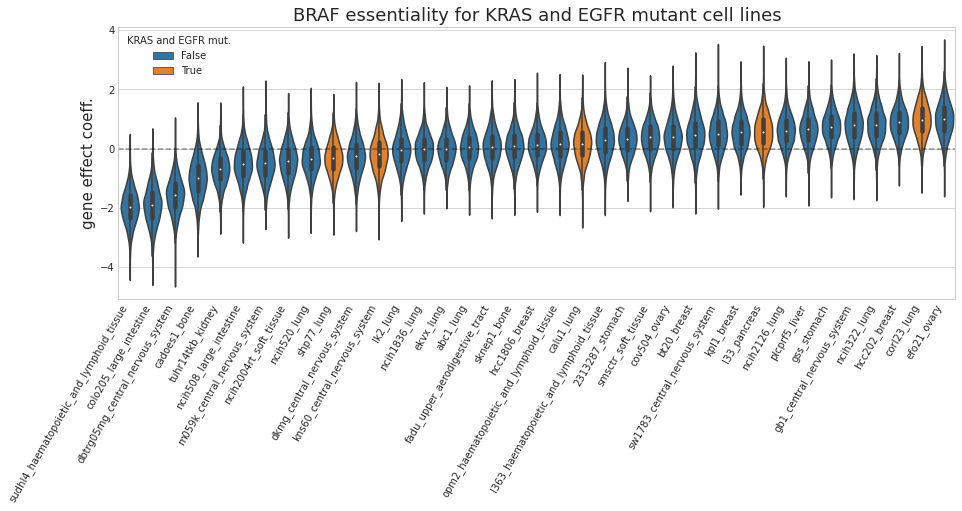

In [97]:
egfr_muts = mutation_data.pipe(lambda x: x[x.hugo_symbol == 'EGFR']).cell_line.to_list()
violin_by_cell_line('BRAF', 'KRAS and EGFR', kras_muts.cell_line.to_list() + egfr_muts)

**TODO: look at effect of the multiplicative scaling factor. Maybe compare results with model 4 where there is no multiplicative factor.**

In [98]:
d2_m4_fit.model_pars

['sigma_c',
 'mu_gbar',
 'sigma_gbar',
 'sigma_g',
 'c',
 'gbar',
 'g',
 'mu_sigma',
 'sigma_sigma',
 'sigma',
 'y_pred']

In [99]:
d2_m5_fit.model_pars

['sigma_c',
 'mu_gbar',
 'sigma_gbar',
 'sigma_g',
 'c',
 'alpha',
 'gbar',
 'g',
 'mu_sigma',
 'sigma_sigma',
 'sigma',
 'y_pred']

In [100]:
m4_cl_data = d2_m4_fit.extract(pars='c')
cl_data = {'m4_c': m4_cl_data['c'].mean(axis=0)} 

In [101]:
m5_cl_data = d2_m5_fit.extract(pars=['c', 'alpha'])
for key, val in m5_cl_data.items():
    cl_data[f'm5_{key}'] = val.mean(axis=0)

In [102]:
cl_df = pd.DataFrame(cl_data)
cl_df.head()

m4_c      m5_c  m5_alpha
0  2.235566  1.388940  0.226152
1  0.848993  0.355141  0.306266
2  0.703887  0.636358  0.487371
3  1.265645  0.658361  0.178976
4 -0.575790  0.103500  0.775101

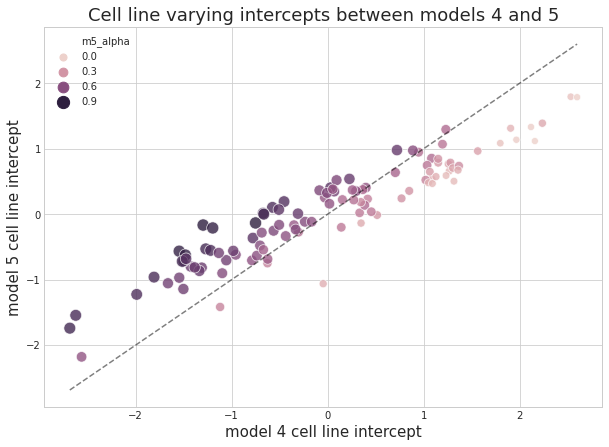

In [116]:
x_vals = np.linspace(np.min(cl_df.m4_c), np.max(cl_df.m4_c))

sns.scatterplot(x='m4_c', y='m5_c', size='m5_alpha', hue='m5_alpha', 
                data=cl_df, sizes=(50, 150), alpha=0.8, legend='brief')
plt.plot(x_vals, x_vals, 'k--', alpha=0.5)
plt.xlabel('model 4 cell line intercept')
plt.ylabel('model 5 cell line intercept')
plt.title('Cell line varying intercepts between models 4 and 5')
plt.show()

In [104]:
def extract_prediction_info(fit, name):
    p = fit.extract('y_pred')['y_pred']
    p_hdi = np.apply_along_axis(az.hdi, axis=0, arr=p, hdi_prob=0.89)
    return {
        f'{name}_pred_mean': p.mean(axis=0),
        f'{name}_pred_hdi_dn': p_hdi[0],
        f'{name}_pred_hdi_up': p_hdi[1],
    }

In [105]:
model_predictions = pd.DataFrame({
    **extract_prediction_info(d2_m4_fit, "m4"), 
    **extract_prediction_info(d2_m5_fit, "m5"),
    'obs': modeling_data.lfc,
    'cell_line': modeling_data.cell_line,
    'gene_symbol': modeling_data.gene_symbol,
    'barcode_sequence': modeling_data.barcode_sequence,
})

In [106]:
model_predictions.head()

m4_pred_mean  m4_pred_hdi_dn  m4_pred_hdi_up  m5_pred_mean  m5_pred_hdi_dn  \
0      0.798723       -0.811882        2.299739      0.742871       -0.748287   
1      1.015390       -0.580458        2.510070      0.779841       -0.867941   
2      1.047552       -0.572622        2.584981      0.936184       -0.649361   
3      1.143413       -0.416845        2.732953      0.876974       -0.743851   
4      0.994660       -0.538631        2.604680      0.827171       -0.709087   

   m5_pred_hdi_up       obs                         cell_line gene_symbol  \
0        2.329097  0.625725                       efo21_ovary        EIF6   
1        2.339018  2.145082  dbtrg05mg_central_nervous_system        EIF6   
2        2.477397  0.932751                       bt20_breast        EIF6   
3        2.407862  1.372030     sw1783_central_nervous_system        EIF6   
4        2.426900  0.803835      kns60_central_nervous_system        EIF6   

        barcode_sequence  
0  ACAGAAGAAATTCTGGCAGAT  
1  ACAGAAGAAATTCTGGCAGAT  
2  ACAGAAGAAATTCTGGCAGAT  
3  ACAGAAGAAATTCTGGCAGAT  
4  ACAGAAGAAATTCTGGCAGAT

In [107]:
genes = np.unique(model_predictions.gene_symbol.astype('string').to_list())
genes.sort()
genes
model_predictions = model_predictions \
    .set_index('gene_symbol') \
    .loc[genes] \
    .reset_index() \
    .reset_index()

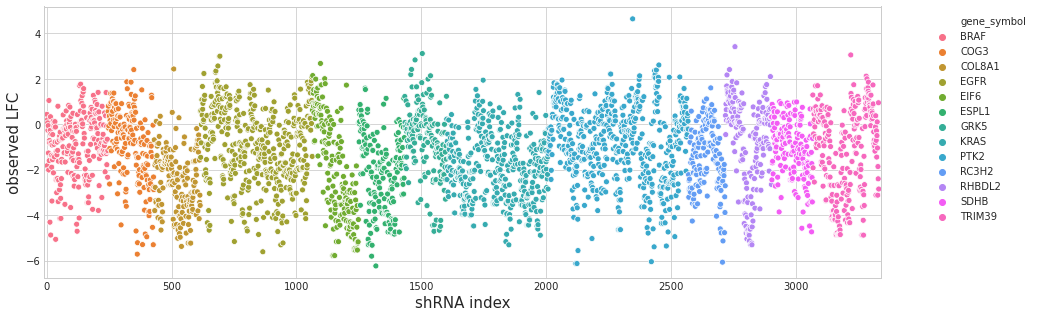

In [114]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x='index', y='obs', hue='gene_symbol', data=model_predictions)
plt.xlabel('shRNA index')
plt.ylabel('observed LFC')
plt.xlim(-10, len(model_predictions)+10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

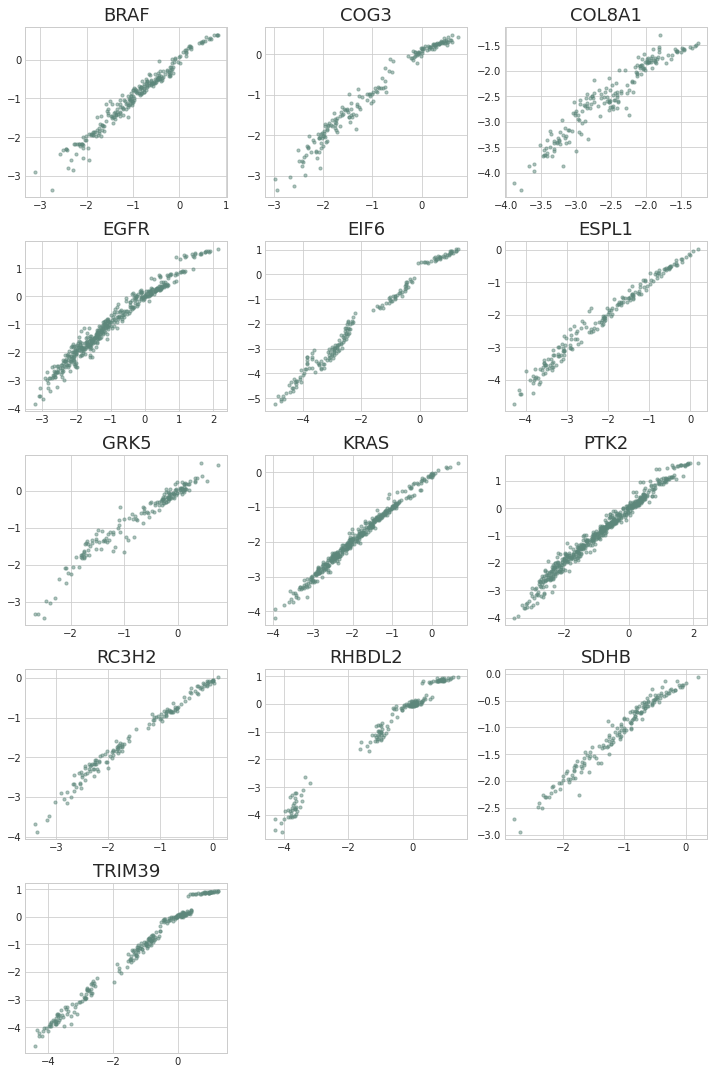

In [109]:
fig, axes = plt.subplots(5, 3, figsize=(10, 15))

for ax, gene in zip(axes.flatten(), genes):
    df = model_predictions[model_predictions.gene_symbol == gene]
    ax.scatter(x=df.m4_pred_mean, y=df.m5_pred_mean, alpha=0.5, s=10, color='#5d877b')
    ax.set_title(gene)

axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

In [110]:
def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--')

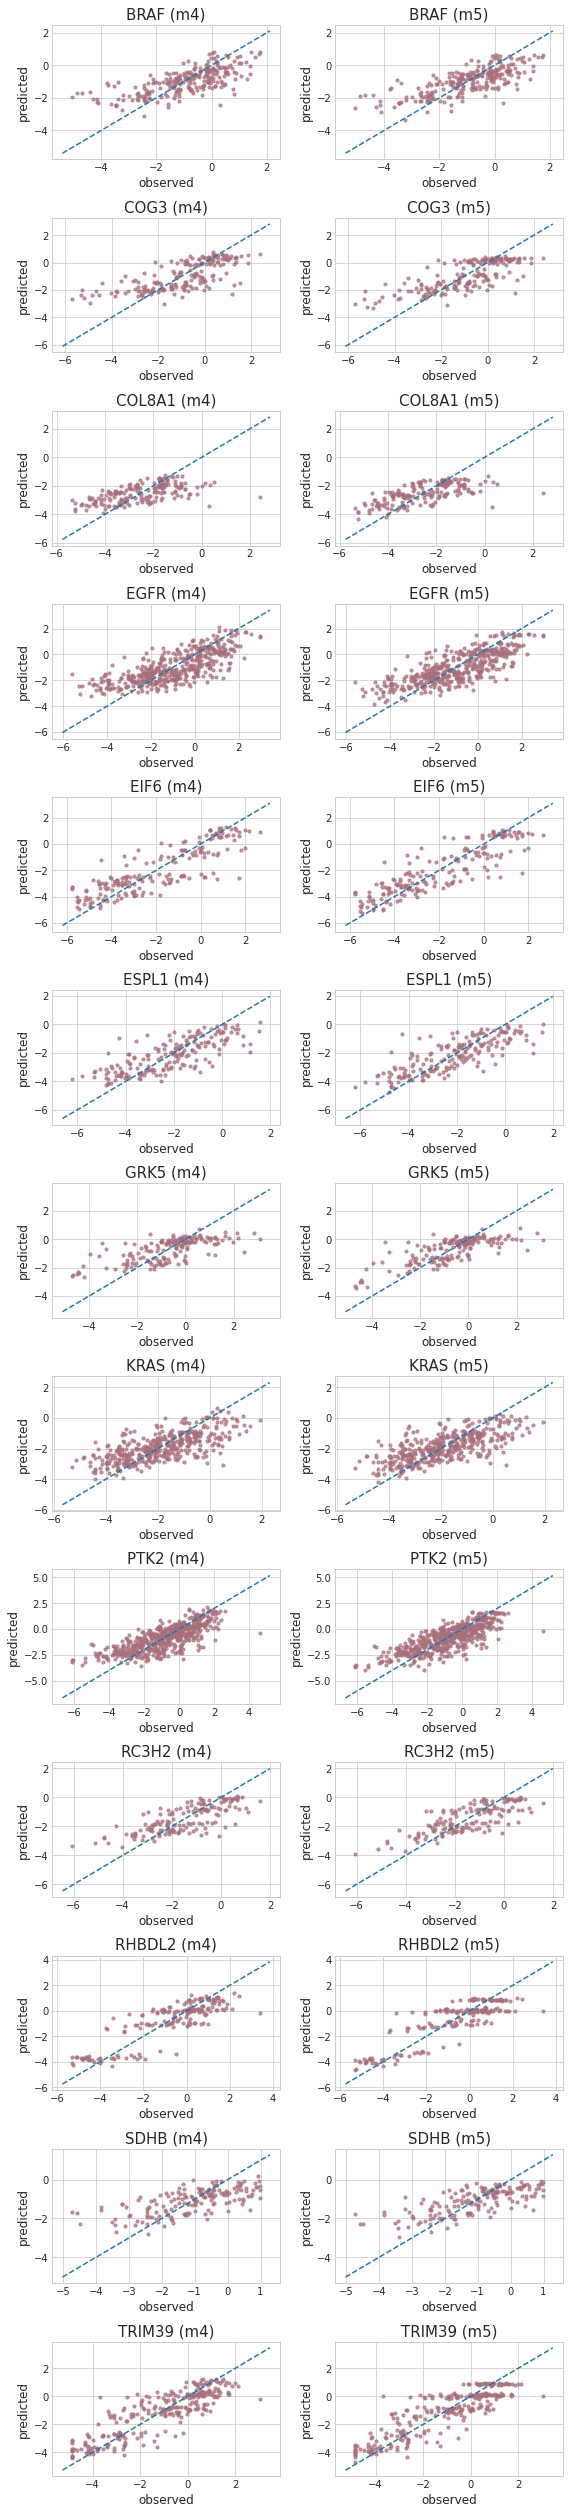

In [111]:
fig, axes = plt.subplots(len(genes), 2, figsize=(8, 35))
for i, gene in enumerate(genes):
    df = model_predictions[model_predictions.gene_symbol == gene]
    for j, m in enumerate(('m4', 'm5')):
        axes[i, j].scatter(df.loc[:, 'obs'], df.loc[:, f'{m}_pred_mean'], 
                           c='#a86f7a', s=10, alpha=0.7)
        abline(axes[i, j], 1, 0)
        axes[i, j].set_title(f'{gene} ({m})', fontsize=15)
        axes[i, j].set_xlabel('observed', fontsize=12)
        axes[i, j].set_ylabel('predicted', fontsize=12)


fig.tight_layout(pad=1.0)
plt.show()

## Model 6. Multiplicative scaling factor and varying intercept for each cell line

There are two new parameters in this model: $a_j$, a varying intercept per cell line, and $\gamma_j$, a multiplicative scaling factor for each cell line.

$$
D_{i|sjl} \sim N(\mu_{i|sjl}, \sigma_s) \\
\mu_{sjl} = a_j + \gamma_j(c_{s} + \alpha_s (\bar g_{l} + g_{jl})) \\
a_j \sim N(0, \sigma_a) \\
\gamma_j \sim N(1, 2) \\
c_s \sim N(0, \sigma_c) \\
\alpha_s \sim \text{Uniform}(0, 1) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_a \sim \text{HalfNormal}(2, 3) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [122]:
d2_m6_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

In [133]:
d2_m6_file = models_dir / 'd2_m6.cpp'
d2_m6 = StanModel_cache(file=d2_m6_file.as_posix())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66c65136081b1616d9b674dc89996d94 NOW.


No cached model - compiling '../models/d2_m6.cpp'.
0.78 minutes to compile model


In [134]:
d2_m6_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m6_fit = d2_m6.sampling(data=d2_m6_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m6_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [135]:
pystan.check_hmc_diagnostics(d2_m6_fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': False}

In [136]:
d2_m6_post = d2_m6_fit.to_dataframe()

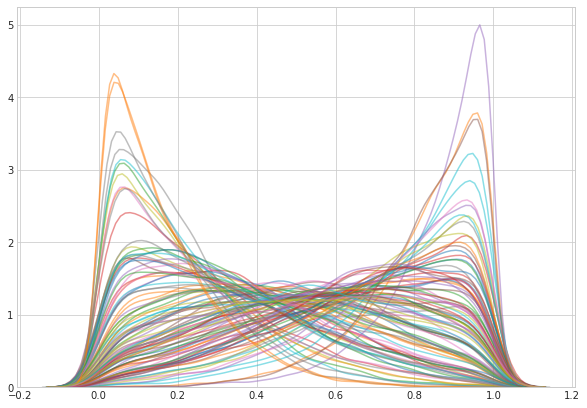

In [137]:
df = d2_m6_post.loc[:, d2_m6_post.columns.str.contains('alpha\[')]
for col in df.columns:
    sns.distplot(df[[col]], hist=False, kde_kws={'alpha': 0.5})

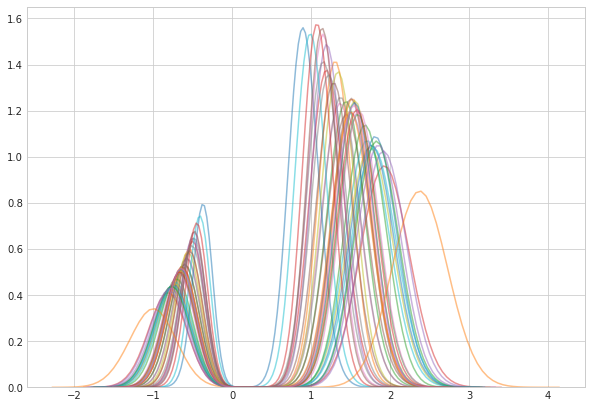

In [139]:
df = d2_m6_post.loc[:, d2_m6_post.columns.str.contains('gamma\[')]
for col in df.columns:
    sns.distplot(df[[col]], hist=False, kde_kws={'alpha': 0.5})

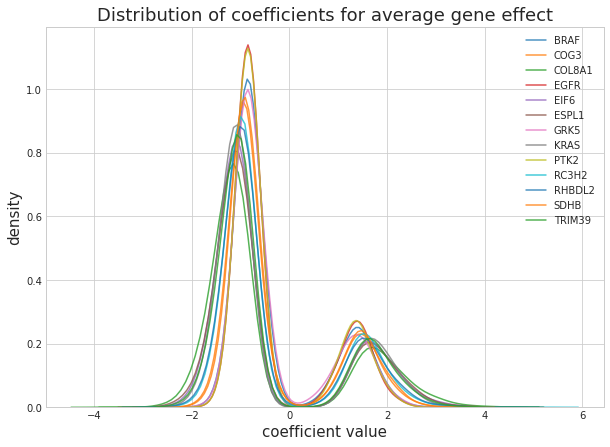

In [128]:
genes_post = d2_m6_post.loc[:, d2_m6_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

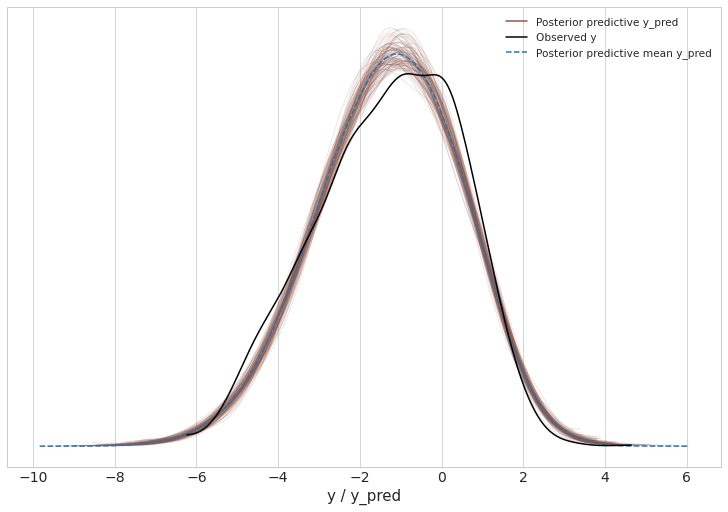

In [140]:
az_d2_m6 = az.from_pystan(posterior=d2_m6_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m6)
az.plot_ppc(az_d2_m6, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

## Model 7. Only a varying intercept for each cell line (no scaling factor)

The previous model had difficult fiting.
This model removes the per-cell-line scaling factor, leaving the parameter for varying effects per cell line.

$$
D_{i|sjl} \sim N(\mu_{i|sjl}, \sigma_s) \\
\mu_{sjl} = a_j + c_{s} + \alpha_s (\bar g_{l} + g_{jl}) \\
a_j \sim N(0, \sigma_a) \\
c_s \sim N(0, \sigma_c) \\
\alpha_s \sim \text{Uniform}(0, 1) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_a \sim \text{HalfNormal}(0, 2) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 3) \\
\sigma_g \sim \text{HalfNormal}(0, 3) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [324]:
d2_m7_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

In [325]:
d2_m7_file = models_dir / 'd2_m7.cpp'
d2_m7 = StanModel_cache(file=d2_m7_file.as_posix())

Using cached StanModel.


In [326]:
d2_m7_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m7_fit = d2_m7.sampling(data=d2_m7_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m7_control,
                           n_jobs=5)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [327]:
pystan.check_hmc_diagnostics(d2_m7_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [328]:
d2_m7_post = d2_m7_fit.to_dataframe()

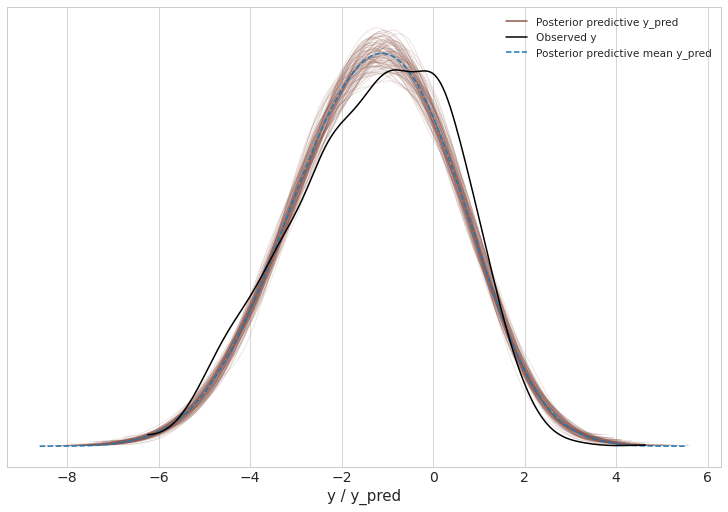

In [329]:
az_d2_m7 = az.from_pystan(posterior=d2_m7_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m7)
az.plot_ppc(az_d2_m7, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [330]:
d2_m7_a_post = pd.DataFrame(d2_m7_fit.extract('a')['a'])

cell_line_map = modeling_data[['cell_line', 'cell_line_idx']] \
    .drop_duplicates() \
    .sort_values('cell_line_idx') \
    .reset_index(drop=True)

d2_m7_a_post.columns = cell_line_map.cell_line

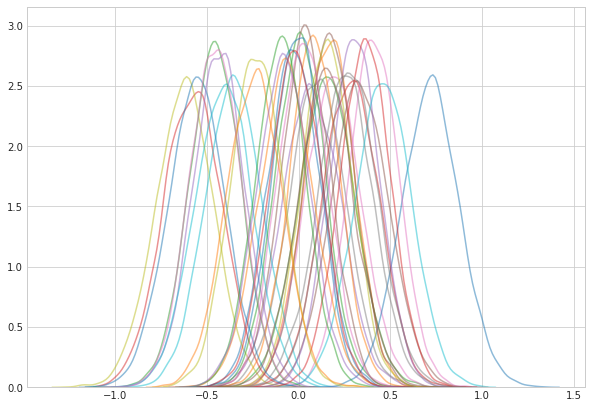

In [331]:
for cell_line in d2_m7_a_post.columns.to_list():
    sns.distplot(d2_m7_a_post[[cell_line]], hist=False, kde_kws={'alpha': 0.5})

In [332]:
d2_m7_pred = pd.DataFrame(d2_m7_fit.extract('y_pred')['y_pred'])
d2_m7_pred.head()

0         1         2         3         4         5         6     \
0  2.135660  0.414827  0.334429  1.169825  0.730670  2.100070 -0.097630   
1 -0.258568  1.589077  0.975810  2.683896  1.944490  2.222514 -0.369773   
2  0.991447  0.995235  0.319739  0.829170  0.861540  1.489871 -0.840679   
3  1.359276  1.887486  2.536779  2.099641  0.495947  0.421383  0.522812   
4  0.403651 -0.367544  0.098439  0.566884  1.336703  0.360488 -1.058102   

       7         8         9     ...      3324      3325      3326      3327  \
0  0.825503  0.811204  0.886321  ... -1.271522 -1.604833 -0.681266 -2.412664   
1  0.907256  1.329136  1.167455  ... -3.554992  0.909750 -1.305267 -0.659696   
2  1.842453  0.537677  1.225023  ...  0.159416 -1.171176 -1.501274 -2.026308   
3  0.178429  0.001630  2.200154  ... -2.485514  0.115954 -0.794616 -1.327708   
4  1.923034  0.040789  2.334603  ... -2.767285 -2.070522 -2.672827 -2.081729   

       3328      3329      3330      3331      3332      3333  
0 -0.092858 -1.769742 -1.023952 -1.709334 -1.446946 -1.867585  
1 -0.430644 -1.464651 -0.405352 -3.262250 -0.406125 -2.403691  
2 -1.028868 -1.797697 -0.161722 -0.608210 -1.747198 -0.662055  
3 -0.756625 -1.725587 -4.247362 -1.169149 -0.628886  0.604209  
4 -0.788420 -2.484335 -1.050932 -1.563766 -1.309522 -0.289561  

[5 rows x 3334 columns]

In [333]:
d2_m7_pred_mean = d2_m7_pred \
    .melt(var_name='data_pt') \
    .groupby('data_pt') \
    .mean()

d2_m7_pred_mean['hdi'] = d2_m7_pred.apply(axis=1, func=lambda x: az.hdi(np.array(x)))

d2_m7_pred_mean = d2_m7_pred_mean \
    .assign(hdi_dn=lambda x: [a[0] for a in x.hdi],
            hdi_up=lambda x: [a[1] for a in x.hdi]) \
    .reset_index()

d2_m7_pred_mean['gene_symbol_idx'] = d2_m7_data['gene']
d2_m7_pred_mean['barcode_sequence_idx'] = d2_m7_data['shrna']

d2_m7_pred_mean = pd.merge(
    d2_m7_pred_mean,
    modeling_data[['gene_symbol', 'gene_symbol_idx']].drop_duplicates(), 
    how='left',
    on='gene_symbol_idx'
)

d2_m7_pred_mean = pd.merge(
    d2_m7_pred_mean,
    modeling_data[['barcode_sequence', 'barcode_sequence_idx']].drop_duplicates(), 
    how='left',
    on='barcode_sequence_idx'
)

d2_m7_pred_mean.head()

data_pt     value                                        hdi    hdi_dn  \
0        0  1.327296   [-4.596127267026097, 1.7751894749567059] -4.596127   
1        1  0.244436  [-4.5335408181883485, 1.9609086301908234] -4.533541   
2        2  0.991050    [-4.41952942019391, 1.9664193474126457] -4.419529   
3        3  0.960443   [-4.723445979399989, 1.7270904559989635] -4.723446   
4        4  1.039913    [-4.578403632973594, 1.648208253996473] -4.578404   

     hdi_up  gene_symbol_idx  barcode_sequence_idx gene_symbol  \
0  1.775189                5                     1        EIF6   
1  1.960909                5                     1        EIF6   
2  1.966419                5                     1        EIF6   
3  1.727090                5                     1        EIF6   
4  1.648208                5                     1        EIF6   

        barcode_sequence  
0  ACAGAAGAAATTCTGGCAGAT  
1  ACAGAAGAAATTCTGGCAGAT  
2  ACAGAAGAAATTCTGGCAGAT  
3  ACAGAAGAAATTCTGGCAGAT  
4  ACAGAAGAAATTCTGGCAGAT

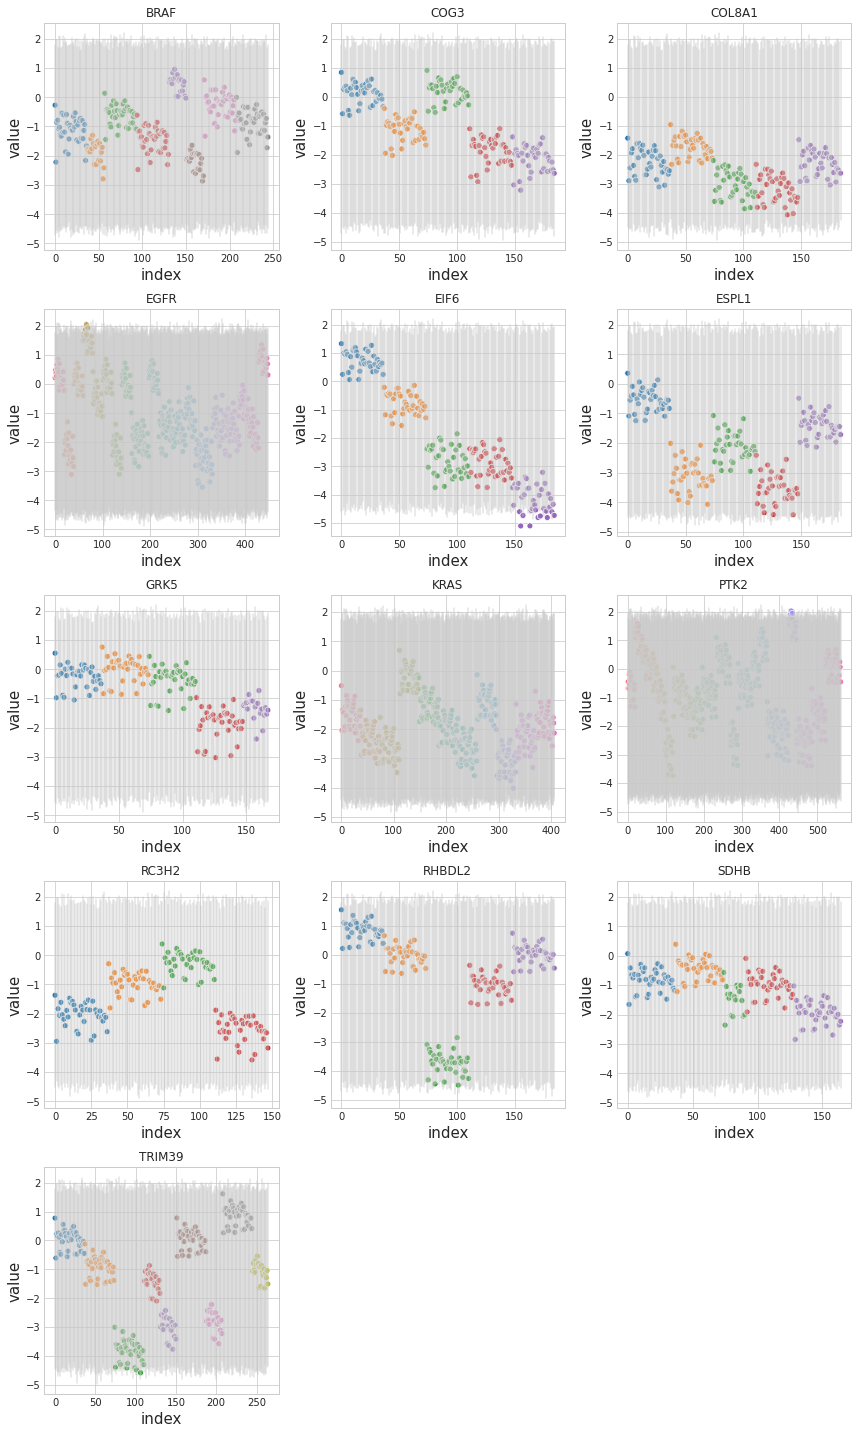

In [335]:
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

genes = np.unique(d2_m7_pred_mean.sort_values('gene_symbol').gene_symbol.to_list())

for ax, gene in zip(axes.flatten(), genes):
    
    g_data = d2_m7_pred_mean[d2_m7_pred_mean.gene_symbol == gene] \
        .reset_index(drop=True) \
        .reset_index()
    
    for i in range(len(g_data)):
        ax.plot((i, i), (g_data.hdi_dn[i], d2_m7_pred_mean.hdi_up[i]), 
                c='#c9c9c9', alpha=0.5)
    
    sns.scatterplot(x='index', y='value', hue='barcode_sequence', data=g_data,
                    legend=False, ax=ax)
    
    ax.set_title(gene, fontsize=12)

axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

In [337]:
d2_m7_pred_mean

data_pt     value                                        hdi    hdi_dn  \
0           0  1.327296   [-4.596127267026097, 1.7751894749567059] -4.596127   
1           1  0.244436  [-4.5335408181883485, 1.9609086301908234] -4.533541   
2           2  0.991050    [-4.41952942019391, 1.9664193474126457] -4.419529   
3           3  0.960443   [-4.723445979399989, 1.7270904559989635] -4.723446   
4           4  1.039913    [-4.578403632973594, 1.648208253996473] -4.578404   
...       ...       ...                                        ...       ...   
3329     3329 -1.649936   [-4.585495669287962, 1.7745792535842833] -4.585496   
3330     3330 -1.139632   [-4.292058452422176, 2.0046199948082952] -4.292058   
3331     3331 -1.293152    [-4.616257206899434, 1.939295593995174] -4.616257   
3332     3332 -1.042668    [-4.399500114545466, 1.695579964952048] -4.399500   
3333     3333 -1.509146    [-4.35022691859504, 2.0816350404236923] -4.350227   

        hdi_up  gene_symbol_idx  barcode_sequence_idx gene_symbol  \
0     1.775189                5                     1        EIF6   
1     1.960909                5                     1        EIF6   
2     1.966419                5                     1        EIF6   
3     1.727090                5                     1        EIF6   
4     1.648208                5                     1        EIF6   
...        ...              ...                   ...         ...   
3329  1.774579               13                   109      TRIM39   
3330  2.004620               13                   109      TRIM39   
3331  1.939296               13                   109      TRIM39   
3332  1.695580               13                   109      TRIM39   
3333  2.081635               13                   109      TRIM39   

           barcode_sequence  
0     ACAGAAGAAATTCTGGCAGAT  
1     ACAGAAGAAATTCTGGCAGAT  
2     ACAGAAGAAATTCTGGCAGAT  
3     ACAGAAGAAATTCTGGCAGAT  
4     ACAGAAGAAATTCTGGCAGAT  
...                     ...  
3329  TGCTCTCATGGGTCTAGATAT  
3330  TGCTCTCATGGGTCTAGATAT  
3331  TGCTCTCATGGGTCTAGATAT  
3332  TGCTCTCATGGGTCTAGATAT  
3333  TGCTCTCATGGGTCTAGATAT  

[3334 rows x 9 columns]

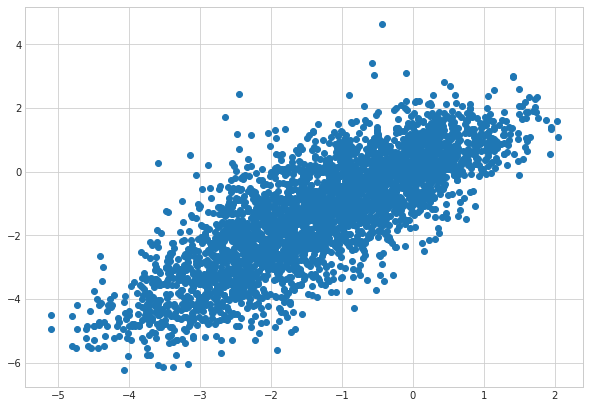

In [338]:
plt.scatter(x=d2_m7_pred_mean.loc[:, 'value'], y=d2_m7_data['y'])
plt.show()